<a href="https://colab.research.google.com/github/pedro-aza/MVP_ML_Analytics_PMAR/blob/main/MVP_ML_PMAR_final_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MVP: *Machine Learning & Analytics*
**Autor:** Pedro Mendes de Azambuja Rodrigues  

**Data:** 26/09/2025

**Dataset:** [Diabetes 130-US Hospitals for Years 1999-2008](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008)


## 1. Escopo, objetivo e definição do problema
1. Escopo, objetivo e definição do problema

Readmissões hospitalares em até 30 dias após a alta são indicadores importantes de qualidade assistencial, pois refletem possíveis falhas na continuidade do cuidado e elevam os custos para o sistema de saúde. Identificar precocemente pacientes com maior risco de retornar pode orientar intervenções direcionadas, reduzir complicações e melhorar o uso de recursos hospitalares.

O objetivo deste projeto é desenvolver modelos de classificação binária para prever a probabilidade de readmissão em 30 dias, utilizando dados tabulares de prontuário eletrônico (informações demográficas, clínicas, laboratoriais e de utilização de serviços). A proposta gera valor ao fornecer alertas de risco no momento da alta, apoiando a tomada de decisão clínica e de gestão, com potencial impacto na segurança do paciente, na qualidade do cuidado e na eficiência operacional do hospital.


## 2. Reprodutibilidade e ambiente
O experimento foi conduzido em Python 3.12, utilizando ambiente Google Colab. As principais bibliotecas empregadas foram:

- `pandas`, `numpy` para manipulação e análise de dados;  
- `scikit-learn` para pré-processamento, regressão logística, métricas e validação;  
- `imbalanced-learn` para métodos de balanceamento e implementação da `BalancedRandomForestClassifier`;  
- `lightgbm` e `catboost` para modelos de gradient boosting;  
- `matplotlib` e `seaborn` para visualização.  


Para garantir reprodutibilidade, foi definida uma semente global (SEED = 42) aplicada em todos os métodos que envolvem aleatoriedade (divisão treino-teste, validação cruzada, inicialização dos modelos).

In [1]:
# -U (ou --upgrade) atualiza, -q suprime a saída detalhada
!pip install -q -U dython catboost lightgbm imbalanced-learn shap


In [2]:
# === Configuração global ===
import warnings
warnings.filterwarnings("ignore")

# === Bibliotecas padrão ===
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === scikit-learn: seleção de dados e validação ===
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    TimeSeriesSplit,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
)

# === scikit-learn: pré-processamento e pipeline ===
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# === Modelos ===
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    VotingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from imblearn.ensemble import BalancedRandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# === Métricas ===
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    silhouette_score,
    precision_recall_curve,
    average_precision_score,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    make_scorer,
    classification_report,
    ConfusionMatrixDisplay
)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# == Matriz de correlação ==
from dython.nominal import associations

# === Outros utilitários ===
from scipy.stats import randint, uniform
import joblib, requests, io
from pathlib import Path
from pandas.api.types import is_categorical_dtype, is_numeric_dtype

# === SHAP ===
import shap

# === Reprodutibilidade ===
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# === Controle de execução do pipeline ===
# True  = carrega pipeline salvo do GitHub (rápido)
# False = refaz o RandomizedSearch (demorado)
LOAD_PRETRAINED = True


### 2.2 Funções python

In [3]:
def evaluate_classification(y_true, y_pred, proba=None):
    acc  = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    roc  = roc_auc_score(y_true, proba[:, 1]) if proba is not None else None
    return {"accuracy": acc, "precision": prec,
            "recall": rec, "f1": f1, "roc_auc": roc}

## 3. Dados: carga, entendimento e qualidade  

**Origem**  
O dataset utilizado foi o Diabetes 130-US hospitals (1999–2008), disponível publicamente no [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). Ele contém informações de 101.766 internações de pacientes com diagnóstico de diabetes em 130 hospitais norte-americanos, abrangendo variáveis demográficas, clínicas, de utilização de serviços e desfecho de readmissão em até 30 dias.  

**Licença / ética**  
Os dados são desidentificados e distribuídos pelo UCI sob fins de pesquisa, sem restrições adicionais de uso. Como se trata de um repositório público e anonimizado, não há necessidade de aprovação ética adicional.  

### 3.1 Estrutura das variáveis  
O banco original possui 47 variáveis, entre elas:  
- Identificadores técnicos: `encounter_id`, `patient_nbr` (removidos da modelagem).  
- Demográficas: `age`, `gender`, `race`.  
- Admissão e alta: `admission_type_id`, `discharge_disposition_id`, `admission_source_id`.  
- Diagnósticos: três códigos ICD-9 principais (`diag_1`, `diag_2`, `diag_3`).  
- Gravidade/uso de recursos: `time_in_hospital`, número de exames e de medicamentos, `number_inpatient`, `number_outpatient`, `number_emergency`.  
- Tratamento: indicadores de uso de insulina e outras medicações.  
- Variável alvo: `readmitted` (readmissão em 30 dias).  

### 3.2 Limpeza dos dados  
Este notebook parte de uma versão já limpa do dataset original, obtida após etapas prévias de tratamento e filtragem:
- Remoção de variáveis com alta taxa de incompletude: `weight`, `payer_code`, `medical_specialty`.  
- Seleção apenas da primeira internação de cada paciente, garantindo independência estatística.  
- Exclusão de casos com óbito ou alta para cuidados paliativos.  
- Agrupamento de variáveis categóricas (diagnósticos, origem e destino da internação) em classes mais amplas, reduzindo sparsidade.  

### 3.3 Considerações de qualidade e vazamento  
- O dataset reflete inconsistências típicas de dados clínicos reais (ausência de variáveis estruturadas, codificações heterogêneas).  
- Foi evitado **vazamento de dados**, garantindo que informações derivadas do desfecho (ex.: tempo até readmissão) não fossem usadas como preditores.  
- Pré-processamento e transformações foram encapsulados em **pipelines do scikit-learn**, assegurando que apenas os dados de treino fossem usados para ajustar imputadores, encoders e escalas.  

**Resumo**  
O dataset final representa internações de pacientes adultos com diabetes, duração entre 1 e 14 dias, sem óbito ou alta para hospice. Cada linha corresponde a uma internação única com informações demográficas, clínicas, uso de recursos e terapêuticas, utilizadas para treinar modelos de predição de readmissão hospitalar em 30 dias.

### 3.1 Dicionário de dados (após a limpeza)

| Variável              | Tipo        | Descrição / Categorias principais |
|-----------------------|-------------|-----------------------------------|
| `encounter_id`        | Numérica    | Identificador único da internação (linha). |
| `patient_nbr`         | Numérica    | Identificador do paciente (pode se repetir em múltiplas internações). |
| `race`                | Categórica  | Raça/cor (AfricanAmerican, Asian, Caucasian, Hispanic, Other). |
| `gender`              | Categórica  | Sexo (0 = Female, 1 = Male). |
| `age`                 | Categórica  | Faixa etária categórica em intervalos de 10 anos. |
| `admission_type_id`   | Categórica  | Tipo de admissão (1=Emergency, 3=Elective, 4=Newborn, etc.). |
| `admission_source_id` | Categórica  | Fonte de admissão (Referral, Transfer, ER, Court/Law, Unknown, etc.). |
| `discharge_disposition_id` | Categórica | Destino da alta (códigos originais UCI/HCUP). |
| `time_in_hospital`    | Numérica    | Dias de internação. |
| `num_lab_procedures`  | Numérica    | Nº de procedimentos laboratoriais. |
| `num_procedures`      | Numérica    | Nº de procedimentos não laboratoriais. |
| `num_medications`     | Numérica    | Nº de medicações distintas durante a internação. |
| `number_outpatient`   | Numérica    | Nº de consultas ambulatoriais prévias. |
| `number_emergency`    | Numérica    | Nº de passagens prévias em emergência. |
| `number_inpatient`    | Numérica    | Nº de internações prévias. |
| `number_diagnoses`    | Numérica    | Nº de diagnósticos registrados. |
| `diag1_group`         | Categórica  | Grupo do diagnóstico principal |
| `A1Cresult`           | Categórica  | Resultado do HbA1c (not_measured, norm, high). |
| `metformin`           | Categórica  | Uso de Metformina (0/1). |
| `repaglinide`         | Categórica  | Uso de Repaglinida (0/1). |
| `nateglinide`         | Categórica  | Uso de Nateglinida (0/1). |
| `glimepiride`         | Categórica  | Uso de Glimepirida (0/1). |
| `glipizide`           | Categórica  | Uso de Glipizida (0/1). |
| `glyburide`           | Categórica  | Uso de Gliburida (0/1). |
| `pioglitazone`        | Categórica  | Uso de Pioglitazona (0/1). |
| `rosiglitazone`       | Categórica  | Uso de Rosiglitazona (0/1). |
| `insulin`             | Categórica  | Uso de Insulina (0/1). |
| `glyburide-metformin` | Categórica  | Uso de Gliburida + Metformina (0/1). |
| `other_drugs`         | Categórica  | Indicador agregado para drogas de baixa frequência (0/1). |
| `diabetesMed`         | Categórica  | Algum medicamento para DM foi usado (0/1). |
| `change`              | Categórica  | Houve mudança de medicação durante a internação (0/1). |
| `readmitted`          | Categórica  | **Variável alvo**: readmissão hospitalar em até 30 dias (0/1). |



In [4]:
# === Carga dos dados (via GitHub RAW) ===

# Raiz “raw” do seu repositório
CSV_URL = "https://raw.githubusercontent.com/pedro-aza/MVP_ML_Analytics_PMAR/main/data/diabetes_data_clean.csv"

# Leitura do dataset
df = pd.read_csv(CSV_URL)

df.head().T


,0,1,2,3,4
encounter_id,149190,64410,500364,16680,35754
patient_nbr,55629189,86047875,82442376,42519267,82637451
race,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,0,0,1,1,1
age,[10-20),[20-30),[30-40),[40-50),[50-60)
admission_type_id,1,1,1,1,1
admission_source_id,7,7,7,7,1
time_in_hospital,3,2,2,1,3
num_lab_procedures,59,11,44,51,31
num_procedures,0,5,1,0,6


In [5]:
# === Verificações iniciais ===
display(df.sample(5))
print("\nFormato:", df.shape)
print("\nTipos:")
print(df.dtypes)
print("\nValores ausentes por coluna:")
print(df.isna().sum())

,encounter_id,patient_nbr,race,gender,age,admission_type_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,pioglitazone,rosiglitazone,insulin,glyburide-metformin,change,diabetesMed,readmitted,diag1_group,discharge_disposition_id,other_drugs
36504,120392682,67732704,Hispanic,1,[60-70),5,7,8,67,2,...,0,0,1,0,1,1,0,3,0,0
66552,196313946,59471226,Caucasian,1,[70-80),1,7,4,37,0,...,0,0,1,0,1,1,0,0,0,0
6213,33549132,18652284,Caucasian,0,[80-90),1,4,6,21,6,...,0,0,1,0,1,1,1,1,0,0
45251,146094444,24011577,AfricanAmerican,1,[40-50),3,1,2,19,0,...,0,0,1,0,0,1,1,0,0,0
40606,132270282,66387672,Caucasian,1,[50-60),1,1,1,9,0,...,0,0,0,0,0,0,0,2,0,0



Formato: (97960, 32)

Tipos:
encounter_id                 int64
patient_nbr                  int64
race                        object
gender                       int64
age                         object
admission_type_id            int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
number_diagnoses             int64
A1Cresult                   object
metformin                    int64
repaglinide                  int64
nateglinide                  int64
glimepiride                  int64
glipizide                    int64
glyburide                    int64
pioglitazone                 int64
rosiglitazone                int64
insulin                      int64
glyburide-metformin          int64
change                       int64
diabetesMed              

### 3.1 Análise exploratória resumida (EDA)

### Variável de desfecho (`readmitted`)

A variável de classificação é binária (readmissão em até 30 dias).  
Observa-se forte desbalanceamento: ~89% dos pacientes não foram readmitidos, contra ~11% que foram.  
Esse desequilíbrio tende a enviesar modelos preditivos em direção à classe majoritária, exigindo técnicas específicas (pesos de classe, algoritmos balanceados ou ajuste de limiar), que serão abordadas na etapa de modelagem.



===Variável de classificação ('redmitted'):===
            Frequência  Porcentagem (%)
readmitted                             
0                86953        88.763781
1                11007        11.236219


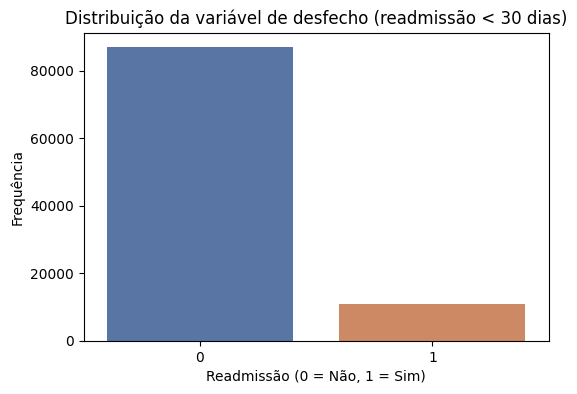

In [6]:
# === frequencia absoluta e porcentagem das classes de desfecho ===
abs_freq = df['readmitted'].value_counts()
rel_freq = df['readmitted'].value_counts(normalize=True) * 100

freq_table = pd.concat([abs_freq, rel_freq], axis=1)
freq_table.columns = ['Frequência', 'Porcentagem (%)']

print(f"\n===Variável de classificação ('redmitted'):===")
print(freq_table.to_string())

# === gráfico ===
plt.figure(figsize=(6,4))
sns.countplot(x="readmitted", data=df, palette="deep")
plt.title("Distribuição da variável de desfecho (readmissão < 30 dias)")
plt.xlabel("Readmissão (0 = Não, 1 = Sim)")
plt.ylabel("Frequência")
plt.show()

### Variáveis demográficas

- **Sexo:** distribuição relativamente equilibrada entre homens (54%) e mulheres (46%).  
- **Raça/Cor:** predominância de pacientes caucasianos (76%), seguidos por afro-americanos (19%). As demais categorias representam <5%. Essa composição é coerente com a demografia dos EUA, mas implica em menor representatividade de grupos alguns grupos (risco de vieses de modelo).  
- **Idade:** variável fornecida em faixas de 10 anos, com maior concentração entre 50–80 anos. Esse padrão reflete a epidemiologia do diabetes, mas limita análises mais granulares (não há idade contínua). A distribuição Tem caldas em jovens e muito idosos, o formanto não é perfeitamente simétrico.



# === Sexo ===
      Frequência  Porcentagem (%)
Sexo                             
0          52774            53.87
1          45186            46.13

# === Raça/Cor ===
                 Frequência  Porcentagem (%)
Raça/Cor                                    
Caucasian             74899            76.46
AfricanAmerican       18928            19.32
Hispanic               2019             2.06
Other                  1483             1.51
Asian                   631             0.64

# === Faixa etária ===
              Frequência  Porcentagem (%)
Faixa etária                             
[70-80)            25070            25.59
[60-70)            21690            22.14
[50-60)            16650            17.00
[80-90)            16512            16.86
[40-50)             9332             9.53
[30-40)             3645             3.72
[90-100)            2668             2.72
[20-30)             1583             1.62
[10-20)              660             0.67
[0-10)               150   

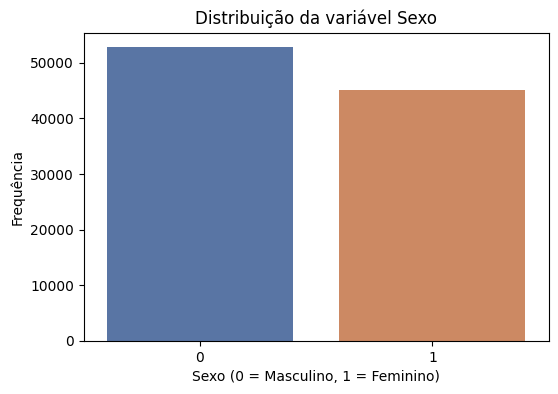

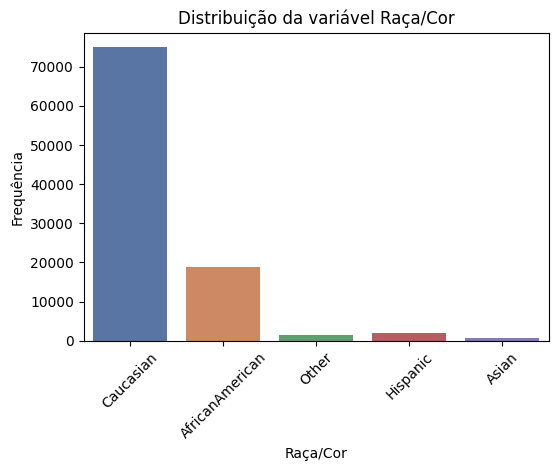

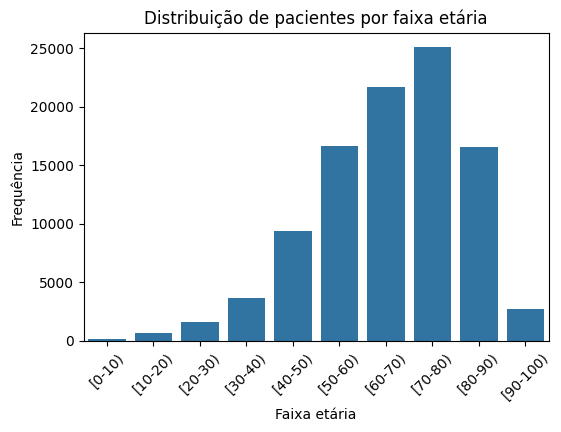

In [7]:
# === Tabelas de frequencias e porcentagens ===

#  Dicionário: nome da coluna: rótulo
var_labels_demo = {
    "gender": "Sexo",
    "race":   "Raça/Cor",
    "age":    "Faixa etária",
}

# Lista de variáveis demográficas categóricas
cat_vars_demo = ["gender", "race", "age"]

#  Exibir tabela de frequência (contagem e %)
for var in cat_vars_demo:
    titulo = var_labels_demo.get(var, var)
    print(f"\n# === {titulo} ===")

    abs_freq = df[var].value_counts(dropna=False)
    rel_freq = df[var].value_counts(normalize=True, dropna=False) * 100

    freq_table = (
        pd.DataFrame({
            "Frequência": abs_freq,
            "Porcentagem (%)": rel_freq.round(2)
        })
        .rename_axis(titulo)
    )

    print(freq_table)

# === Gráficos ===

# = Sexo =
plt.figure(figsize=(6,4))
sns.countplot(x="gender", data=df, palette="deep")
plt.title("Distribuição da variável Sexo")
plt.xlabel("Sexo (0 = Masculino, 1 = Feminino)")
plt.ylabel("Frequência")
plt.show()

# = Raça =
plt.figure(figsize=(6,4))
sns.countplot(x="race", data=df, palette="deep")
plt.title("Distribuição da variável Raça/Cor")
plt.xlabel("Raça/Cor")
plt.ylabel("Frequência")
plt.xticks(rotation=45)
plt.show()

# = Idade =

# Definir a ordem correta das categorias
age_order = [
    "[0-10)", "[10-20)", "[20-30)", "[30-40)", "[40-50)",
    "[50-60)", "[60-70)", "[70-80)", "[80-90)", "[90-100)"
]

# Converter para categórica ordenada
df["age"] = pd.Categorical(df["age"], categories=age_order, ordered=True)

# Gráfico de barras
plt.figure(figsize=(6,4))
sns.countplot(x="age", data=df, order=age_order)
plt.xticks(rotation=45)
plt.title("Distribuição de pacientes por faixa etária")
plt.xlabel("Faixa etária")
plt.ylabel("Frequência")
plt.show()


### Utilização prévia de serviços de saúde
As contagens de internações, visitas ambulatoriais e visitas de emergência prévias exibem forte assimetria: a maior parte dos pacientes apresenta zero eventos, enquanto um pequeno subgrupo acumula até 76 ocorrências.


# === Estatísticas descritivas de utilização de serviços prévios ===
      number_inpatient  number_outpatient  number_emergency
mean          0.644334           0.373724          0.201521
std           1.272526           1.280191          0.944173
min           0.000000           0.000000          0.000000
25%           0.000000           0.000000          0.000000
50%           0.000000           0.000000          0.000000
75%           1.000000           0.000000          0.000000
max          21.000000          42.000000         76.000000


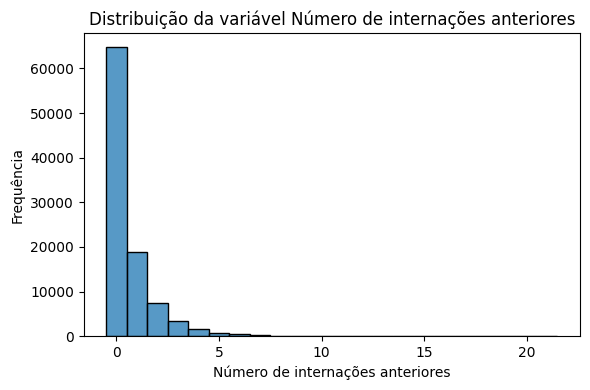

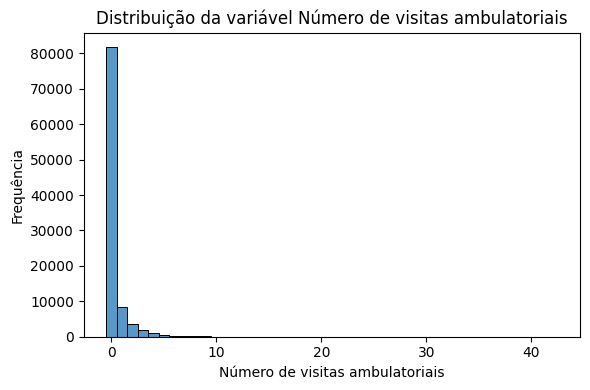

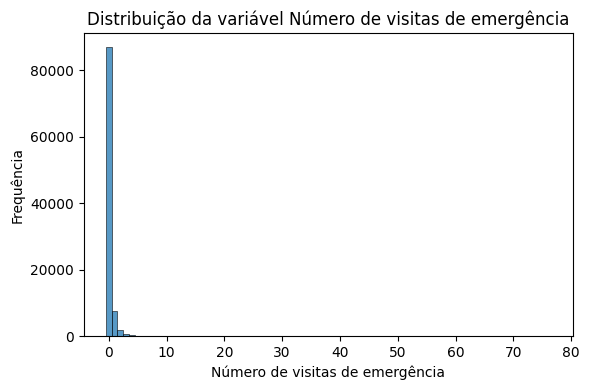

In [8]:
# === Utilização de serviços prévios ===
# Dicionário: nome da coluna ➜ rótulo legível
var_labels_servicos = {
    "number_inpatient" : "Número de internações anteriores",
    "number_outpatient": "Número de visitas ambulatoriais",
    "number_emergency" : "Número de visitas de emergência"
}

# Lista de variáveis numéricas (contagens)
num_vars_servicos = list(var_labels_servicos.keys())

# --- Estatísticas descritivas ---
print("\n# === Estatísticas descritivas de utilização de serviços prévios ===")
tabela_desc_serv = df[num_vars_servicos].describe().drop(index="count")
print(tabela_desc_serv)

# --- Histogramas individuais ---
for col in num_vars_servicos:
    plt.figure(figsize=(6, 4))

    # bins inteiros adequados ao range real da variável
    max_val = df[col].max()
    bins = range(0, int(max_val) + 2)  # +2 p/ incluir o último valor

    sns.histplot(df[col], bins=bins, discrete=True)
    plt.title(f"Distribuição da variável {var_labels_servicos[col]}")
    plt.xlabel(var_labels_servicos[col])
    plt.ylabel("Frequência")
    plt.tight_layout()
    plt.show()


### Variáveis de internação

- **Tempo de internação:** distribuição assimétrica à direita, concentrada em 2–6 dias, mas sem outliers extremos (limite fixo em 14 dias).  
- **Exames laboratoriais:** quase simétrica, mas com leve cauda à direita (>100 exames).  
- **Procedimentos:** fortemente assimétrica à direita, maioria com 0–1.  
- **Medicamentos:** assimétrica à direita, com cauda longa em pacientes polimedicados (até >80).



# === Estatísticas descritivas das variáveis de internação ===
      time_in_hospital  num_lab_procedures  num_procedures  num_medications
mean          4.393753           43.089128        1.344243        16.043007
std           2.984763           19.689026        1.705749         8.131165
min           1.000000            1.000000        0.000000         1.000000
25%           2.000000           32.000000        0.000000        10.000000
50%           4.000000           44.000000        1.000000        15.000000
75%           6.000000           57.000000        2.000000        20.000000
max          14.000000          132.000000        6.000000        81.000000


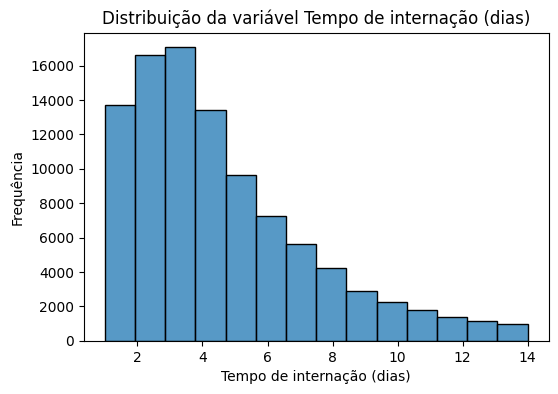

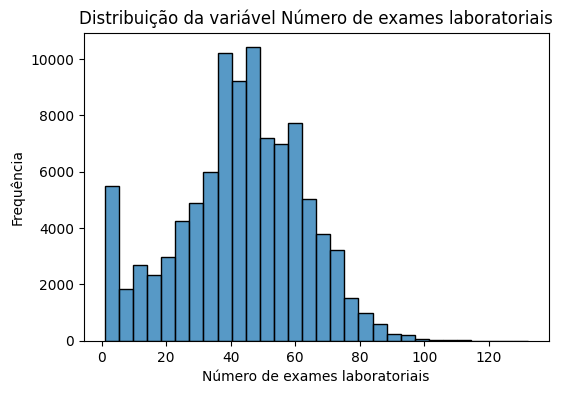

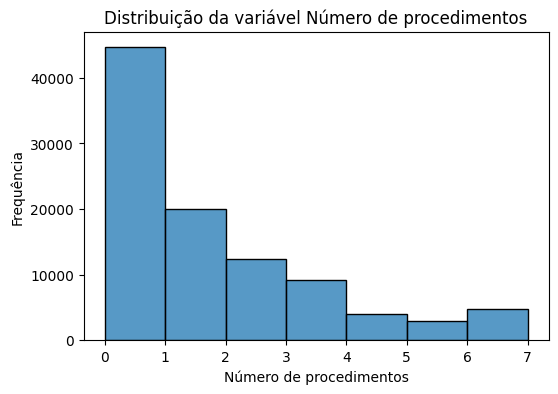

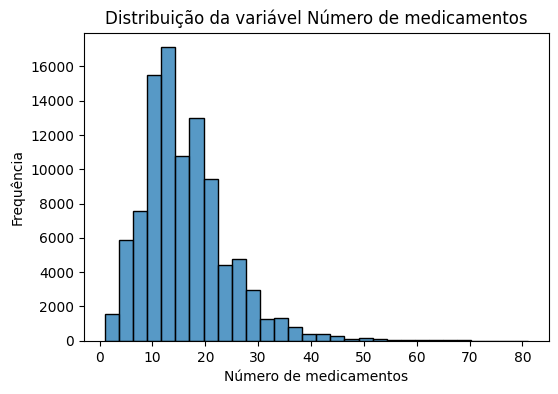

In [9]:
# === Internação atual ===
# Dicionário: nome da coluna ➜ rótulo
var_labels_internacao = {
    "time_in_hospital": "Tempo de internação (dias)",
    "num_lab_procedures": "Número de exames laboratoriais",
    "num_procedures": "Número de procedimentos",
    "num_medications": "Número de medicamentos"
}

# Lista de variáveis numéricas de internação
num_vars_internacao = list(var_labels_internacao.keys())

# === Tabelas de resumo ===
print("\n# === Estatísticas descritivas das variáveis de internação ===")
tabela_desc = df[num_vars_internacao].describe().drop(index="count")
print(tabela_desc)

# === Internação atual — histogramas ===

# === Tempo de internação (dias) ===
plt.figure(figsize=(6,4))
sns.histplot(df["time_in_hospital"], bins=14)
plt.title("Distribuição da variável Tempo de internação (dias)")
plt.xlabel("Tempo de internação (dias)")
plt.ylabel("Frequência")
plt.show()

# === Número de exames laboratoriais ===
plt.figure(figsize=(6,4))
sns.histplot(df["num_lab_procedures"], bins=30)
plt.title("Distribuição da variável Número de exames laboratoriais")
plt.xlabel("Número de exames laboratoriais")
plt.ylabel("Frequência")
plt.show()

# === Número de procedimentos ===
# bins inteiros para representar 0,1,2,3,4,5,6
plt.figure(figsize=(6,4))
sns.histplot(df["num_procedures"], bins=range(0,8))
plt.title("Distribuição da variável Número de procedimentos")
plt.xlabel("Número de procedimentos")
plt.ylabel("Frequência")
plt.show()

# === Número de medicamentos ===
plt.figure(figsize=(6,4))
sns.histplot(df["num_medications"], bins=30)
plt.title("Distribuição da variável Número de medicamentos")
plt.xlabel("Número de medicamentos")
plt.ylabel("Frequência")
plt.show()



### Diagnósticos principais

- Todos os pacientes do dataset têm diabetes mellitus, mas esse nem sempre foi o diagnóstico primário da internação.  
- O grupo mais frequente é de doenças circulatórias, seguido de respiratórias e digestivas.  
- A predominância de diagnósticos cardiovasculares reflete comorbidades associadas ao diabetes.  
- A distribuição é desbalanceada entre capítulos diagnósticos, o que pode levar os modelos a aprender melhor os padrões das categorias majoritárias e ter menor desempenho nas minoritárias. A categoria “Outros” reúne diagnósticos pouco frequentes, permitindo reduzir a sparsidade e facilitar o aprendizado do modelo.

### Número de diagnósticos por paciente

A maioria dos pacientes apresenta multiplos diagnósticos, o complexidade clínica da coorte. A distribuição é relativamente concentrada e não apresenta caudas longas ou outliers relevantes, embora haja poucos casos com até 16 diagnósticos.  





# === Frequência dos grupos diagnósticos principais ===
                             Frequência  Porcentagem (%)
Capítulo diagnóstico                                    
Doenças circulatórias             29347            29.96
Outras doenças                    17462            17.83
Doenças respiratórias             13896            14.19
Doenças digestivas                 9165             9.36
Diabetes mellitus                  8424             8.60
Lesões e envenenamentos            6701             6.84
Doenças genito-urinárias           4958             5.06
Doenças musculoesqueléticas        4775             4.87
Neoplasias                         3232             3.30


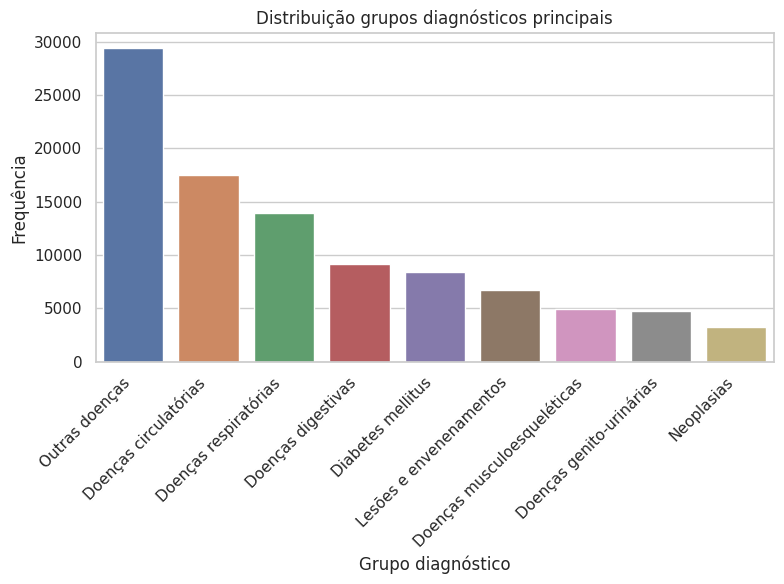


# === Estatísticas descritivas: número de diagnósticos por paciente ===
mean     7.439822
std      1.924623
min      1.000000
25%      6.000000
50%      8.000000
75%      9.000000
max     16.000000
Name: number_diagnoses, dtype: float64


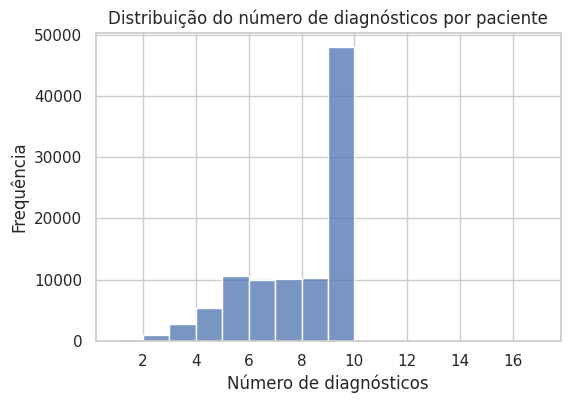

In [10]:
# === Diagnósticos ===
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
cor = sns.color_palette("deep")[0]

# Dicionário de labels para diag1_group
diag1_labels = {
    0: "Outras doenças",
    1: "Doenças circulatórias",
    2: "Doenças respiratórias",
    3: "Doenças digestivas",
    4: "Diabetes mellitus",
    5: "Lesões e envenenamentos",
    6: "Doenças musculoesqueléticas",
    7: "Doenças genito-urinárias",
    8: "Neoplasias"
}

# = Grupo diágnóstico =

# Tabela
print("\n# === Frequência dos grupos diagnósticos principais ===")
abs_freq = df["diag1_group"].value_counts(dropna=False)
rel_freq = df["diag1_group"].value_counts(normalize=True, dropna=False) * 100
freq_table = (
    pd.DataFrame({"Frequência": abs_freq, "Porcentagem (%)": rel_freq.round(2)})
    .rename_axis("Capítulo diagnóstico")
    .rename(index=diag1_labels)   # aplica os labels
)
print(freq_table)

# Gráfico
plt.figure(figsize=(8,6))
sns.countplot(x="diag1_group", data=df, order=df["diag1_group"].value_counts().index, palette = "deep")
plt.title("Distribuição grupos diagnósticos principais")
plt.xlabel("Grupo diagnóstico")
plt.ylabel("Frequência")

# Substitui os ticks numéricos pelos labels
plt.xticks(ticks=range(len(diag1_labels)), labels=[diag1_labels[i] for i in range(len(diag1_labels))], rotation=45, ha="right")
plt.tight_layout()
plt.show()


# = Numero de diagnósticos =

# Tabela
print("\n# === Estatísticas descritivas: número de diagnósticos por paciente ===")
tabela_desc = df["number_diagnoses"].describe().drop("count")
print(tabela_desc)

# Gráfico
plt.figure(figsize=(6,4))
sns.histplot(df["number_diagnoses"], bins=range(1,18))
plt.title("Distribuição do número de diagnósticos por paciente")
plt.xlabel("Número de diagnósticos")
plt.ylabel("Frequência")
plt.show()


###Hemoglobina glicada (`A1Cresult`)

A variável A1Crefere-se ao exame de hemoglobina glicada, marcador importante do controle do diabetes. No dataset, a maioria dos pacientes (83%) não teve o exame registrado, sendo a categoria “não medido” explicitamente assinalada em vez de tratada como ausente. Mantive essa codificação para preservar a informação, mas o forte desbalanceamento reduz seu potencial discriminativo no modelo.


# === Frequência de A1Cresult ===
                 Frequência  Porcentagem (%)
A1C (resultado)                             
Não medido            81562            83.26
Alto                  11540            11.78
Normal                 4858             4.96


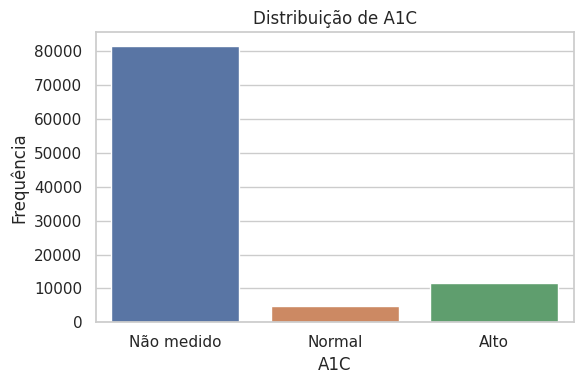

In [11]:
# === Exames laboratoriais — Hemoglobina glicada (A1Cresult) ===

# Labels e ordem (do mais “neutro” ao mais “alterado”)
a1c_order_en = ["not_measured", "norm", "high"]
a1c_labels_pt = {
    "not_measured": "Não medido",
    "norm": "Normal",
    "high": "Alto"
}

# Garantir categórica ordenada (mantém os valores originais)
if "A1Cresult" in df.columns:
    df["A1Cresult"] = pd.Categorical(df["A1Cresult"],
                                     categories=a1c_order_en,
                                     ordered=True)

# = Tabela =
print("\n# === Frequência de A1Cresult ===")
abs_freq = df["A1Cresult"].value_counts(dropna=False)
rel_freq = df["A1Cresult"].value_counts(normalize=True, dropna=False) * 100
freq_table = (
    pd.DataFrame({"Frequência": abs_freq, "Porcentagem (%)": rel_freq.round(2)})
    .rename_axis("A1C (resultado)")
    .rename(index=a1c_labels_pt)  # aplica labels PT na tabela
)
print(freq_table)

# = Gráfico =
plt.figure(figsize=(6,4))
sns.countplot(x="A1Cresult", data=df, order=a1c_order_en, palette="deep")
plt.title("Distribuição de A1C")
plt.xlabel("A1C")
plt.ylabel("Frequência")
# substituir ticks em inglês por rótulos PT
plt.xticks(ticks=range(len(a1c_order_en)),
           labels=[a1c_labels_pt[v] for v in a1c_order_en])
plt.tight_layout()
plt.show()


### Estratégia de tratamento para diabetes
- **diabetesMed:** ~77% em uso de medicaçoes específicas para diabetes
- **change:** ~46% tiveram mudança durante a internação, sinal de gravidade/ajuste terapêutico, variável interessante para a predição.




# === Uso de medicamento para diabetes (diabetesMed) ===
             Frequência  Proporção (%)
diabetesMed                           
1                 75324          76.89
0                 22636          23.11


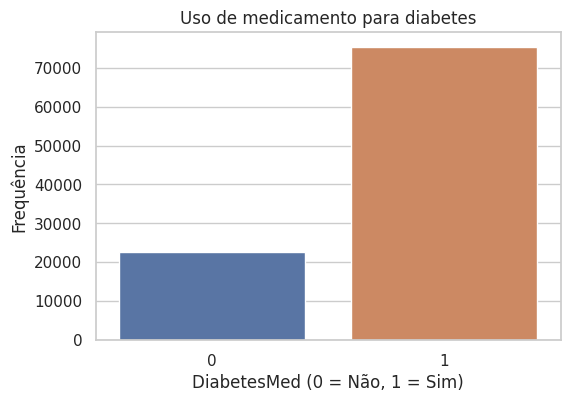


# === Mudança de medicamento durante a internação (change) ===
        Frequência  Proporção (%)
change                           
0            52699           53.8
1            45261           46.2


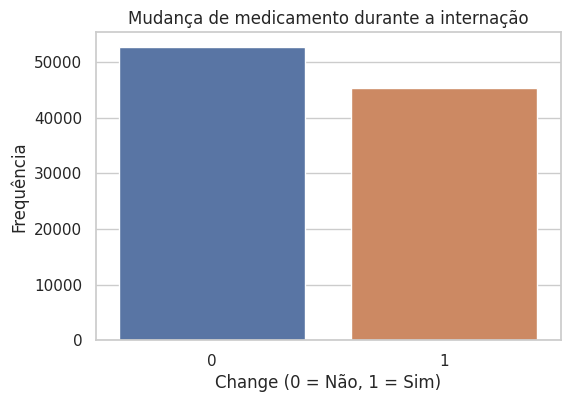

In [12]:
# === Estratégia de tratamento para diabetes ===
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
cor = sns.color_palette("deep")[0]

# = Uso de medicamento para diabetes =
#Tabela
print("\n# === Uso de medicamento para diabetes (diabetesMed) ===")
abs_freq = df["diabetesMed"].value_counts(dropna=False)
rel_freq = df["diabetesMed"].value_counts(normalize=True, dropna=False) * 100
freq_table = pd.DataFrame({"Frequência": abs_freq, "Proporção (%)": rel_freq.round(2)})
print(freq_table)

# Gráfico
plt.figure(figsize=(6,4))
sns.countplot(x="diabetesMed", data=df, palette="deep")
plt.title("Uso de medicamento para diabetes")
plt.xlabel("DiabetesMed (0 = Não, 1 = Sim)")
plt.ylabel("Frequência")
plt.show()

# = Mudança de medicamento para diabetes =
# Tabela
print("\n# === Mudança de medicamento durante a internação (change) ===")
abs_freq = df["change"].value_counts(dropna=False)
rel_freq = df["change"].value_counts(normalize=True, dropna=False) * 100
freq_table = pd.DataFrame({"Frequência": abs_freq, "Proporção (%)": rel_freq.round(2)})
print(freq_table)

# Gráfico
plt.figure(figsize=(6,4))
sns.countplot(x="change", data=df, palette="deep")
plt.title("Mudança de medicamento durante a internação")
plt.xlabel("Change (0 = Não, 1 = Sim)")
plt.ylabel("Frequência")
plt.show()


### Tratamento – medicamentos específicos

- **Insulina** é o mais frequente (~53%). Os medicamentos com frequência < 0.5% estão agrupados em outros. As colunas não são mutuamente exclusivas.



# === Frequência e proporção de uso de medicamentos ===
                        Frequência  Proporção (%)
Insulina                     52127          53.21
Metformina                   19316          19.72
Glipizida                    12201          12.46
Gliburida                    10229          10.44
Pioglitazona                  7110           7.26
Rosiglitazona                 6148           6.28
Glimepirida                   4985           5.09
Repaglinida                   1520           1.55
Nateglinida                    692           0.71
Gliburida + Metformina         675           0.69
Outros fármacos                495           0.51


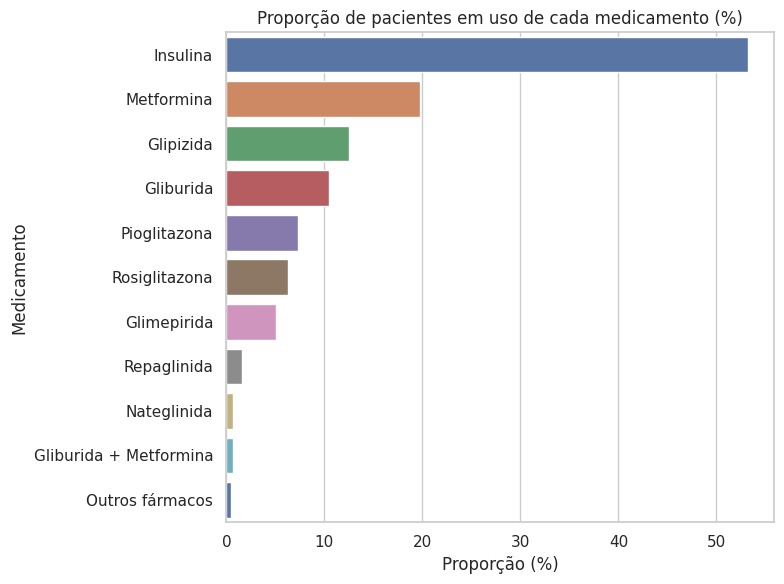

In [13]:
# === Tratamento: medicamentos específicos para diabetes utilizados ===

# Labels legíveis
drug_labels = {
    "metformin": "Metformina",
    "repaglinide": "Repaglinida",
    "nateglinide": "Nateglinida",
    "glimepiride": "Glimepirida",
    "glipizide": "Glipizida",
    "glyburide": "Gliburida",
    "pioglitazone": "Pioglitazona",
    "rosiglitazone": "Rosiglitazona",
    "insulin": "Insulina",
    "glyburide-metformin": "Gliburida + Metformina",
    "other_drugs": "Outros fármacos"
}

# Selecionar colunas que existem no df
drug_cols = [col for col in drug_labels.keys() if col in df.columns]

# Frequências absolutas e proporcionais
freq_abs = df[drug_cols].sum()
freq_rel = df[drug_cols].mean() * 100

# Montar tabela
drug_table = pd.DataFrame({
    "Frequência": freq_abs.astype(int),
    "Proporção (%)": freq_rel.round(2)
})
drug_table.index = [drug_labels[col] for col in drug_table.index]
drug_table = drug_table.sort_values(by="Frequência", ascending=False)

# === Tabela ===
print("\n# === Frequência e proporção de uso de medicamentos ===")
print(drug_table.to_string())

# === Gráfico ===
plt.figure(figsize=(8,6))
sns.barplot(x=drug_table["Proporção (%)"],
            y=drug_table.index,
            palette="deep")
plt.title("Proporção de pacientes em uso de cada medicamento (%)")
plt.xlabel("Proporção (%)")
plt.ylabel("Medicamento")
plt.tight_layout()
plt.show()


### Variáveis administrativas da internação

- **Tipo de admissão:** predomínio de emergências (~72%), com eletivas em torno de 19%. Distribuição relativamente simples; categorias “não mapeado” devem ser mantidas explicitamente.  
- **Fonte de admissão:** maioria chega do pronto-socorro (57%) ou encaminhamento ambulatorial (30%).
- **Destino da alta:** predominam alta para casa (73%) e transferências (25%). Outras saídas são marginais.



# === Tipo de admissão ===
                              Frequência  Proporção (%)
Tipo de admissão                                       
Emergência                         70244          71.71
Eletiva                            18446          18.83
Recém-nascido                         10           0.01
Não disponível / não mapeado        9260           9.45


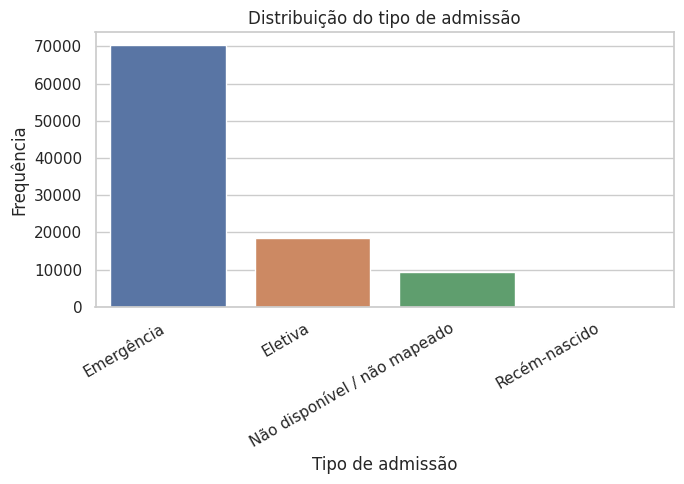


# === Fonte de admissão ===
                                Frequência  Proporção (%)
Fonte de admissão                                        
Encaminhamento ambulatorial          29671          30.29
Transferência de outra unidade        5815           5.94
Pronto-socorro                       55940          57.10
Ordem judicial/policial                 16           0.02
Informação indisponível               6513           6.65
Inválido / crítico                       5           0.01


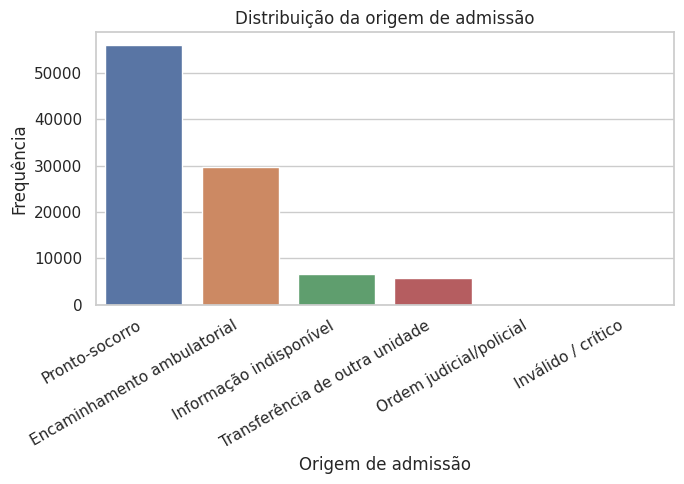


# === Destino da alta ===
                          Frequência  Proporção (%)
Destino da alta (código)                           
Casa / autocuidado             71572          73.06
Transferência                  24071          24.57
Outros                          1706           1.74
Alta contra recomendação         611           0.62


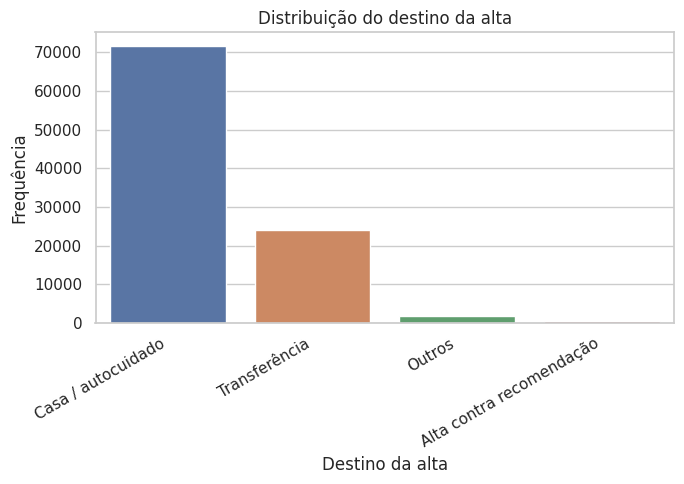

In [14]:
# === Variáveis administrativas da internação ===


# = Tipo de admissão =

admission_type_labels = {
    1: "Emergência",
    3: "Eletiva",
    4: "Recém-nascido",
    5: "Não disponível / não mapeado",
    9: "Desconhecido",
}

print("\n# === Tipo de admissão ===")
abs_freq = df["admission_type_id"].value_counts(dropna=False).sort_index()
rel_freq = df["admission_type_id"].value_counts(normalize=True, dropna=False).sort_index() * 100
freq_table = (
    pd.DataFrame({"Frequência": abs_freq, "Proporção (%)": rel_freq.round(2)})
    .rename_axis("Tipo de admissão")
    .rename(index=admission_type_labels)
)
print(freq_table.to_string())

order = df["admission_type_id"].value_counts().index
plt.figure(figsize=(7,5))
ax = sns.countplot(x="admission_type_id", data=df, order=order, palette="deep")
ax.set_title("Distribuição do tipo de admissão")
ax.set_xlabel("Tipo de admissão")
ax.set_ylabel("Frequência")
ax.set_xticklabels([admission_type_labels.get(v, str(v)) for v in order],
                   rotation=30, ha="right")
plt.tight_layout()
plt.show()



# = Origem de admissão =

admission_source_labels = {
    1: "Encaminhamento ambulatorial",
    4: "Transferência de outra unidade",
    7: "Pronto-socorro",
    8: "Ordem judicial/policial",
    9: "Informação indisponível",
    11: "Inválido / crítico",
    12: "Não mapeado",
}

print("\n# === Fonte de admissão ===")
abs_freq = df["admission_source_id"].value_counts(dropna=False).sort_index()
rel_freq = df["admission_source_id"].value_counts(normalize=True, dropna=False).sort_index() * 100
freq_table = (
    pd.DataFrame({"Frequência": abs_freq, "Proporção (%)": rel_freq.round(2)})
    .rename_axis("Fonte de admissão")
    .rename(index=admission_source_labels)
)
print(freq_table.to_string())

order = df["admission_source_id"].value_counts().index
plt.figure(figsize=(7,5))
ax = sns.countplot(x="admission_source_id", data=df, order=order, palette="deep")
ax.set_title("Distribuição da origem de admissão")
ax.set_xlabel("Origem de admissão")
ax.set_ylabel("Frequência")
ax.set_xticklabels([admission_source_labels.get(v, str(v)) for v in order],
                   rotation=30, ha="right")
plt.tight_layout()
plt.show()


# = Destino da alta =
disp_code_labels = {
    0: "Casa / autocuidado",
    1: "Transferência",
    2: "Outros",
    3: "Alta contra recomendação",
}

print("\n# === Destino da alta ===")
abs_freq = df["discharge_disposition_id"].value_counts(dropna=False).sort_index()
rel_freq = df["discharge_disposition_id"].value_counts(normalize=True, dropna=False).sort_index() * 100

freq_table = (
    pd.DataFrame({
        "Frequência": abs_freq.astype("Int64"),
        "Proporção (%)": rel_freq.round(2)
    })
    .rename_axis("Destino da alta (código)")
    .rename(index=disp_code_labels)
)
print(freq_table.to_string())

order = df["discharge_disposition_id"].value_counts().index
plt.figure(figsize=(7,5))
ax = sns.countplot(x="discharge_disposition_id", data=df, order=order, palette="deep")
ax.set_title("Distribuição do destino da alta")
ax.set_xlabel("Destino da alta")
ax.set_ylabel("Frequência")
ax.set_xticklabels([disp_code_labels.get(v, str(v)) for v in order],
                   rotation=30, ha="right")
plt.tight_layout()
plt.show()



## Engenharia de atributos: Tranformação da variável `age`
A variável idade foi originalmente fornecida em intervalos categóricos de 10 anos (ex.: [20–30), [30–40)). Para permitir que os modelos explorassem sua natureza ordenada e contínua, transformei esses intervalos em pontos médios (ex.: [20–30) para 25 anos). Essa abordagem preserva a ordem natural da idade e reduz a dimensionalidade em relação ao one-hot encoding.

In [15]:
# === Converir variável original ===
print(df["age"].value_counts().sort_index())


age
[0-10)        150
[10-20)       660
[20-30)      1583
[30-40)      3645
[40-50)      9332
[50-60)     16650
[60-70)     21690
[70-80)     25070
[80-90)     16512
[90-100)     2668
Name: count, dtype: int64


In [16]:
# === Criar dicionário de midpoints ===
age_mid_map = {
    "[0-10)": 5,
    "[10-20)": 15,
    "[20-30)": 25,
    "[30-40)": 35,
    "[40-50)": 45,
    "[50-60)": 55,
    "[60-70)": 65,
    "[70-80)": 75,
    "[80-90)": 85,
    "[90-100)": 95
}

# === Nova variável com midpoints ===
df["age_midpoint"] = df["age"].map(age_mid_map)

# === Conferir ===
print(df[["age", "age_midpoint"]].head(15))

         age age_midpoint
0    [10-20)           15
1    [20-30)           25
2    [30-40)           35
3    [40-50)           45
4    [50-60)           55
5    [60-70)           65
6    [70-80)           75
7    [80-90)           85
8   [90-100)           95
9    [40-50)           45
10   [60-70)           65
11   [40-50)           45
12   [80-90)           85
13   [60-70)           65
14   [60-70)           65


In [17]:
# substituir a variável age pela nova variável
df = df.drop(columns=["age"]).rename(columns={"age_midpoint": "age"})

## Matriz de correlações

Para explorar as associações entre as variáveis do dataset, utilizamos a função `associations()` da biblioteca **dython**.

**Preparação**  
As variáveis foram organizadas em listas separadas (numéricas e categóricas) antes da chamada da função.

**Métricas aplicadas**  
- **Pearson *r*** para pares *numérico × numérico*  
- **Correlação-razão** para pares *categórico × numérico*  
- **Cramér’s V** para pares *categórico × categórico*

**Tratamento de valores ausentes**  
Empregou-se *pair-wise deletion* (`nan_strategy="drop_sample_pairs"`), descartando apenas as observações faltantes no par avaliado.

**Interpretação da visualização**  
Os coeficientes variam de **0** (nenhuma associação) a **1** (associação perfeita). Como Cramér’s V e a correlação-razão são medidas não-direcionais, interpretamos apenas a **força** da relação e não o sentido.



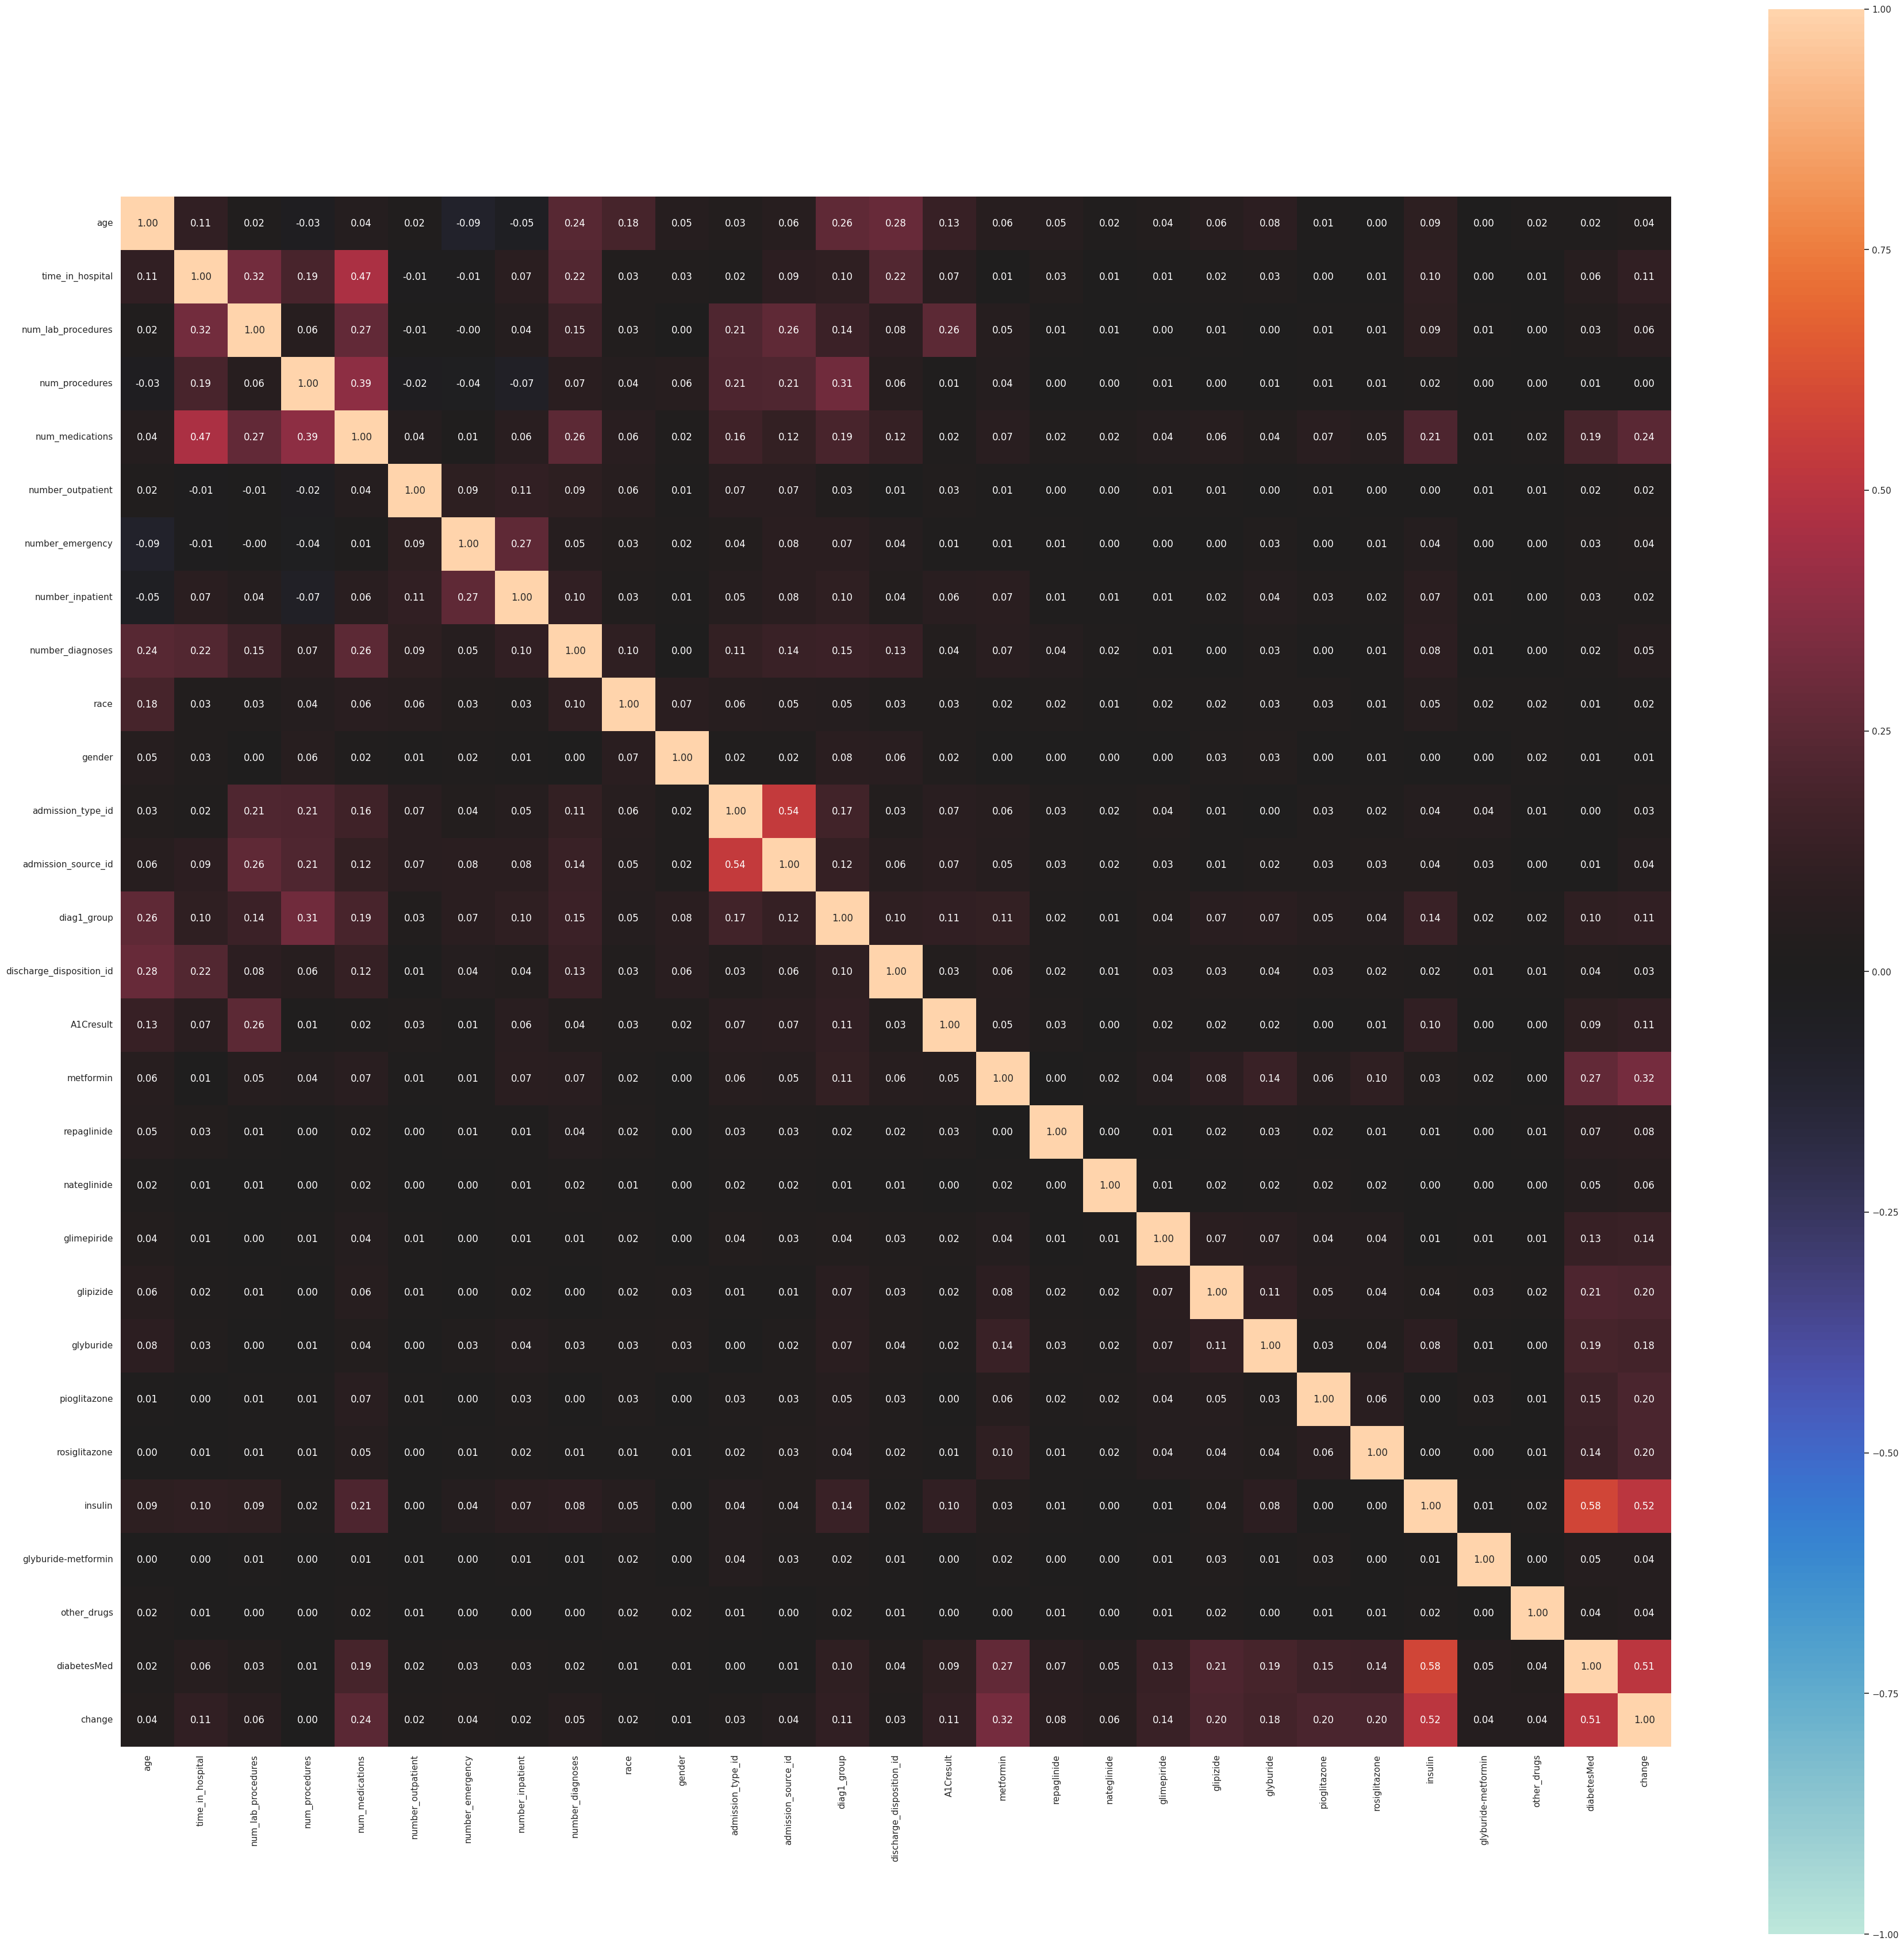

In [18]:
# == Listas de variáveis ==

num_vars = [
    "age",  # já convertida para numérica (ponto médio) antes desta etapa
    "time_in_hospital", "num_lab_procedures", "num_procedures",
    "num_medications", "number_outpatient", "number_emergency",
    "number_inpatient", "number_diagnoses"
]

cat_vars = [
    "race", "gender", "admission_type_id", "admission_source_id",
    "diag1_group", "discharge_disposition_id", "A1Cresult",
    "metformin", "repaglinide", "nateglinide", "glimepiride",
    "glipizide", "glyburide", "pioglitazone", "rosiglitazone",
    "insulin", "glyburide-metformin",
    "other_drugs", "diabetesMed", "change",
]


# == Matriz de correlações == #

# Selecão de colunas ---
cols_keep = num_vars + cat_vars
df_corr = df[cols_keep].copy()

# Garantir numéricas como numéricas
df_corr[num_vars] = df_corr[num_vars].apply(pd.to_numeric, errors="coerce")

# Converter categóricas pandas->object (ou string)
for c in cat_vars:
    # se já for category/boolean/etc., force para string segura
    df_corr[c] = df_corr[c].astype(str)

# Rodar o associations
assoc_df, fig = associations(
    df_corr,
    nominal_columns=cat_vars,
    nom_nom_assoc='cramer',
    cramers_v_bias_correction=True,
    nan_strategy='drop_sample_pairs',
    plot=True,
)


 ## Engenharia de atributos: Uso de antidiabéticos
 As variáveis `insulin` (uso de insulina) e `diabetesMed` (uso de qualquer antidiabético) apresentaram correlação moderada (0,58), refletindo redundância de informação, já que a insulina é o medicamento mais frequentemente utilizado. Além disso, os demais fármacos individuais tiveram baixa frequência. Para reduzir multicolinearidade, sintetizamos essas informações em uma nova variável:
 -  `treat_type` — categórica (0 = nenhum, 1 = apenas medicamentos orais, 2 = insulina ± orais).



In [19]:
# = flags de drogas originais =
drug_cols = [
    "insulin", "metformin", "glipizide", "glyburide", "glimepiride",
    "pioglitazone", "rosiglitazone", "repaglinide", "nateglinide",
    "glyburide-metformin", "other_drugs", "diabetesMed"
]
drug_flags = drug_cols[:-1]   # sem diabetesMed


# = treat_type =
# 0 = nenhum antidiabético
# 1 = orais apenas (diabetesMed==1 & insulin==0)
# 2 = insulina ± orais (insulin==1)

df["treat_type"] = np.nan

df.loc[df["diabetesMed"] == 0, "treat_type"] = 0
df.loc[(df["diabetesMed"] == 1) & (df["insulin"] == 0), "treat_type"] = 1
df.loc[df["insulin"] == 1, "treat_type"] = 2

df["treat_type"] = pd.Categorical(df["treat_type"], categories=[0,1,2], ordered=True)


# = remover colunas originais =
df = df.drop(columns=drug_cols)



In [20]:
print("\n# === Frêquencias da variável treat_type ===")
print(df["treat_type"].value_counts(dropna=False))


# === Frêquencias da variável treat_type ===
treat_type
2    52127
1    23197
0    22636
Name: count, dtype: int64


 ## Exclusao da variável `admission_source_id`
 As variáveis `admission_source_id` (origem da admissão) e `admission_type_id` (tipo de admisssão) apresentaram correlação moderada (0,54), refletindo redundância de informação, já que em ambas a categoria mais frequente é emergência. De modo geral, as demais categorias de `admission_source_id` mostraram baixa frequência e não acrescentaram informações relevantes para o objetivo do modelo. Por esse motivo, optamos por excluir `admission_source_id`, mantendo apenas `admission_type_id` na modelagem.

In [21]:
# === Excluir admission_source_id do dataframe ===
df = df.drop(columns=["admission_source_id"])

In [22]:
# == Verificaão do dataset após modificacóes das variáveis == #
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97960 entries, 0 to 97959
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   encounter_id              97960 non-null  int64   
 1   patient_nbr               97960 non-null  int64   
 2   race                      97960 non-null  object  
 3   gender                    97960 non-null  int64   
 4   admission_type_id         97960 non-null  int64   
 5   time_in_hospital          97960 non-null  int64   
 6   num_lab_procedures        97960 non-null  int64   
 7   num_procedures            97960 non-null  int64   
 8   num_medications           97960 non-null  int64   
 9   number_outpatient         97960 non-null  int64   
 10  number_emergency          97960 non-null  int64   
 11  number_inpatient          97960 non-null  int64   
 12  number_diagnoses          97960 non-null  int64   
 13  A1Cresult                 97960 non-null  cate

## Nova matriz de correlaçoes após as mudanças nas variáveis

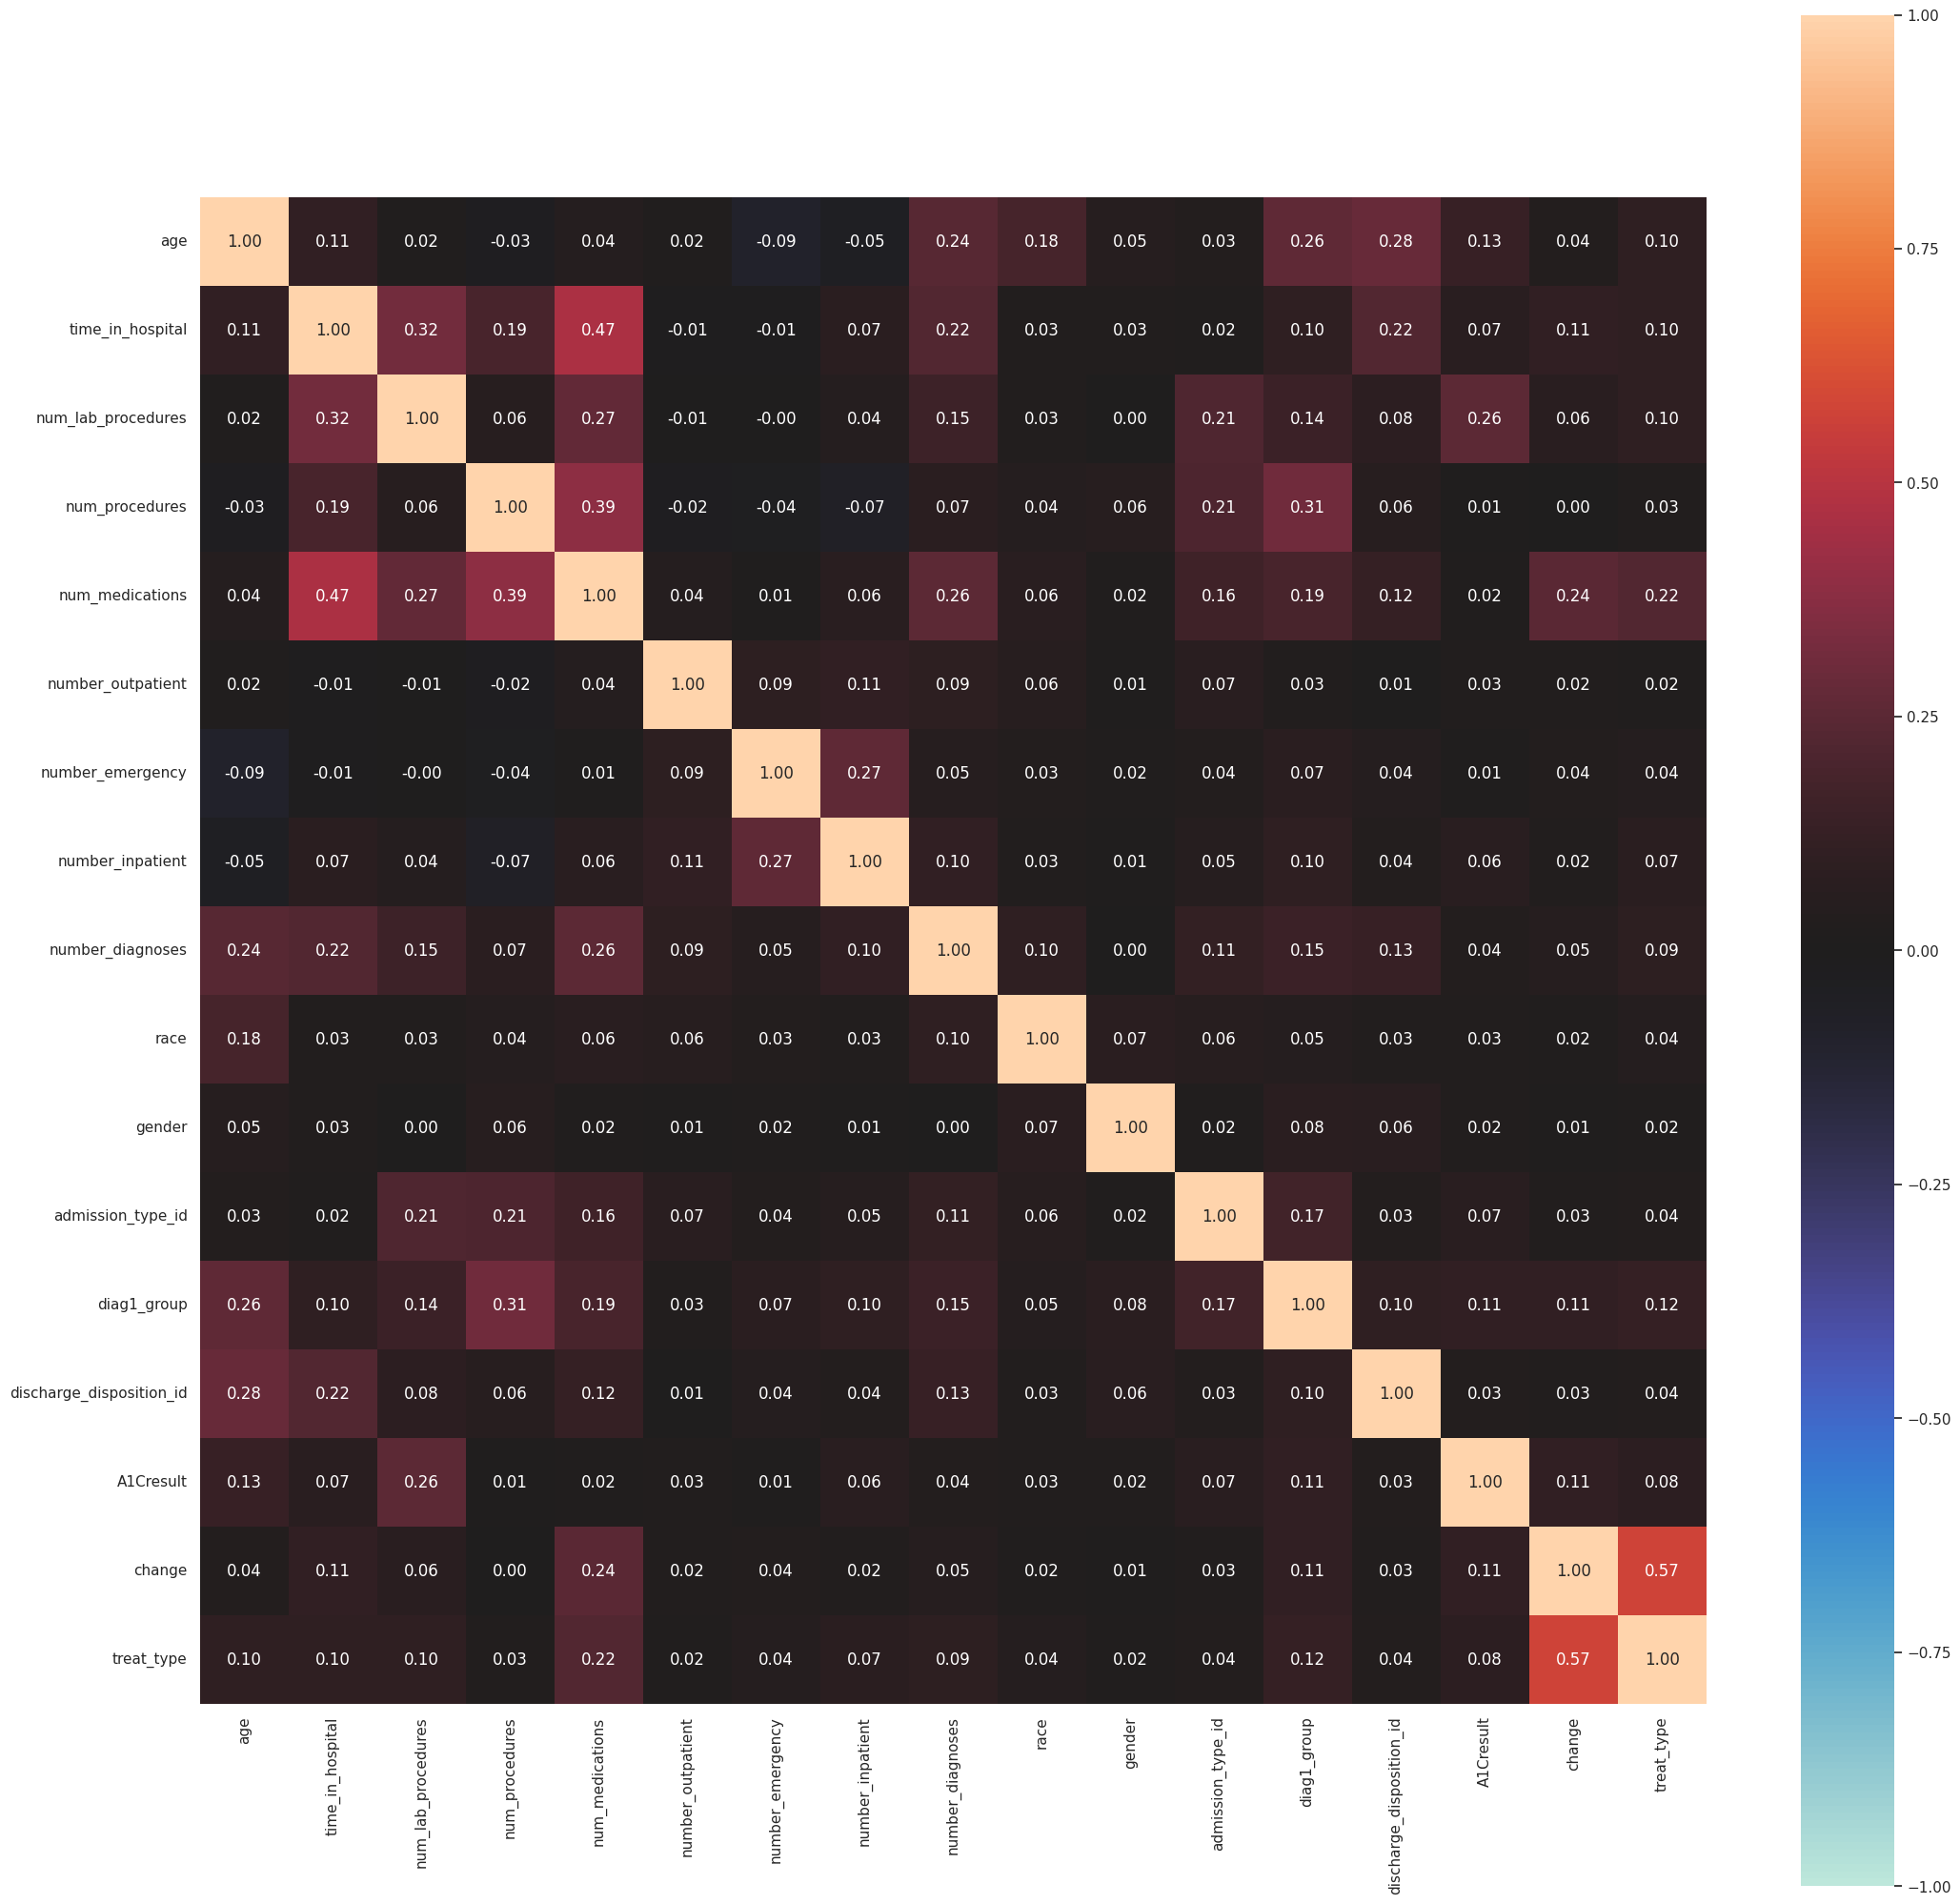

In [24]:
# == Listas atualizadas de variáveis == #


# Numéricas contínuas/discretas
num_vars = [
    "age",
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses"
]

# Categóricas nominais/ordinais
cat_vars = [
    "race",
    "gender",
    "admission_type_id",
    "diag1_group",
    "discharge_disposition_id",
    "A1Cresult",
    "change",
    "treat_type"              # nova categórica criada
]

# == Matriz de correlações == #

# Selecão de colunas ---
cols_keep = num_vars + cat_vars
df_corr = df[cols_keep].copy()

# Garantir numéricas como numéricas
df_corr[num_vars] = df_corr[num_vars].apply(pd.to_numeric, errors="coerce")

# Converter categóricas pandas->object (ou string)
for c in cat_vars:
    # se já for category/boolean/etc., force para string segura
    df_corr[c] = df_corr[c].astype(str)

# Rodar o associations
assoc_df, fig = associations(
    df_corr,
    nominal_columns     = cat_vars,       # inclui binárias
    nom_nom_assoc       = 'cramer',
    cramers_v_bias_correction = True,     # reduz viés
    nan_strategy        = 'drop_sample_pairs',
    plot                = True
)


## Manutenção das variáveis `change` e `treat type`

Apesar da correlação moderada entre change (Mudança de prescrição)e treat_type (tipo de tratamento) (correlação de 0,57), mantive ambas por refletirem dimensões distintas: treat_type descreve o regime terapêutico, enquanto change indica se houve modificação durante a internação. Avaliei a multicolinearidade pelo VIF (Variance Inflation Factor), medida que estima quanto a variância de um coeficiente é inflada pela correlação com outras variáveis do modelo. Valores < 5 são geralmente considerados aceitáveis. No nosso caso os VIFs ficaram < 3, indicando ausência de multicolinearidade relevante.

In [ ]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ------------------------------------------------------------
# Treat_type é categórica (0/1/2) e change é binária:
# transformaçao das colunas em dummies numéricas
# ------------------------------------------------------------
cols_to_check = ["treat_type", "change"]

X = pd.get_dummies(
        df[cols_to_check],
        drop_first=True,
        dtype=float
     )

# Calcular VIF para cada coluna da matriz X

vif_df = pd.DataFrame({
    "feature": X.columns,
    "VIF":     [variance_inflation_factor(X.values, i)
                for i in range(X.shape[1])]
})

print("\n# === Variance Inflation Factor ===")
print(vif_df)


### 4. Definição do target, variáveis e divisão dos dados

O objetivo do modelo é prever a readmissão hospitalar em até 30 dias, definida pela variável readmitted (0 = não readmitido, 1 = readmitido).

As colunas encounter_id e patient_nbr são identificadores administrativos e foram removidas, pois não têm valor preditivo.

As demais variáveis foram mantidas como features.

A base foi dividida em treino (80%) e teste (20%) utilizando holdout estratificado, garantindo que a proporção de pacientes readmitidos seja mantida em ambos os conjuntos.

In [ ]:
# === Definiçao do target,features e divisão dos dados ===
# Target (readmissão hospitalar em até 30 dias)
target = "readmitted"

# Variáveis descartadas (identificadores administrativos)
id_cols = ["encounter_id", "patient_nbr"]  # não usar como features

# Construção de X (features) e y (target)
X = df.drop(columns=id_cols + [target]).copy()
y = df[target].copy()

# Divisão Treino/Teste
# - Usamos holdout estratificado (mantém proporção 0/1)
# - 80% treino / 20% teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=SEED,
    stratify=y
)

# Relatório inicial
print("Tipo de problema: classificacao")
print(f"Target: {target}")
print(f"N features: {X.shape[1]}")
print(f"Treino: {X_train.shape} | Teste: {X_test.shape}")


### 5. Tratamento de dados e Pipeline de pré-processamento

- Numéricas: imputação pela mediana + padronização* com StandardScaler. A idade foi convertida para valores médios numéricos.

- Categóricas: imputação pela moda + one-hot encoding, com remoção automática de redundâncias (drop="if_binary") e agrupamento de categorias raras.

- O pipeline é integrado ao modelo, evitando vazamento de dados e garantindo validação consistente.

\* Optei pela padronização (z-score) em vez da normalização min–máx porque as variáveis numéricas têm escalas muito distintas e distribuições assimétricas. O z-score equaliza a influência dos atributos, acelera e estabiliza a convergência da regressão logística (especialmente sob regularização L2) e é menos sensível a outliers do que o min–máx, sem prejuízo de interpretabilidade já que as unidades originais não são o foco da análise.





In [ ]:
# Listas de variáveis por tipo
# Numéricas contínuas/discretas
num_vars = [
    "age", # já convertida para ponto médico
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses"
]

# Categóricas nominais/ordinais
cat_vars = [
    "race",
    "gender",
    "admission_type_id",
    "diag1_group",
    "discharge_disposition_id",
    "A1Cresult",
    "change",
    "treat_type"
]

# Pipelines por tipo
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore", # evita multicolinearidade nas 0/1
                              drop="if_binary",
                              sparse_output=False)),
])

# ColumnTransformer final
preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_vars),
    ("cat", categorical_pipe, cat_vars),
])

### 6. Baseline e modelos candidatos

O target apresenta desbalanceamento (poucos pacientes são readmitidos em 30 dias). Para evitar que os modelos priorizem apenas a classe majoritária, todas as abordagens incluem estratégias de balanceamento.

* Baseline (DummyClassifier): prevê sempre a classe majoritária, servindo como referência mínima.

* Logistic Regression (balanceada): modelo linear simples com class_weight="balanced".

* Balanced Random Forest: florestas com undersampling interno.

* LightGBM: boosting eficiente com is_unbalance=True.

* CatBoost: boosting otimizado para variáveis categóricas, com pesos automáticos.

Esses modelos permitem comparar abordagens lineares, baseadas árvores, e boosting.

In [ ]:
# = Baseline =
baseline = Pipeline([
    ("pre",  preprocess),                                 # OHE + scaler
    ("model", DummyClassifier(strategy="most_frequent",
                              random_state=SEED))
])

# = Modelos candidatos (com balanceamento) =
candidates = {
    # Reg. logística balanceada
    "LogReg_bal": Pipeline([
        ("pre", preprocess),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            n_jobs=-1,
            random_state=SEED
        ))
    ]),

    # Balanced Random Forest (undersampling interno)
    "BalRF": Pipeline([
        ("pre", preprocess),
        ("model", BalancedRandomForestClassifier(
            n_estimators=400,
            random_state=SEED,
            n_jobs=-1
        ))
    ]),

    # LightGBM com peso de classe
    "LightGBM": Pipeline([
        ("pre", preprocess),
        ("model", LGBMClassifier(
            objective="binary",
            n_estimators=800,
            is_unbalance=True,
            learning_rate=0.05,
            random_state=SEED,
            n_jobs=-1
        ))
    ]),

    # CatBoost
    "CatBoost": Pipeline([
        ("pre", preprocess),
        ("model", CatBoostClassifier(
            iterations=800,
            depth=6,
            learning_rate=0.03,
            loss_function="Logloss",
            auto_class_weights  = "Balanced",
            verbose=0,
            random_state=SEED
        ))
    ])
}

#### 6.1 Avaliação rápida

Cada modelo foi treinado no conjunto de treino (80%) e avaliado no teste (20%). As métricas utilizadas foram:

- Accuracy: indica a proporção de acertos totais. Contudo, em bases desbalanceadas como esta, um modelo que sempre prevê “não readmitido” já teria alta acurácia, por isso esta métrica é pouco informativa sozinha.

- Precision: entre os pacientes previstos como readmitidos, quantos de fato foram. Alta precisão reduz alarmes falsos e evita sobrecarga de recursos assistenciais em pacientes que não precisariam de intervenção.

- Recall (sensibilidade): entre os readmitidos reais, quantos foram detectados. Alta sensibilidade é essencial para não deixar de identificar pacientes de alto risco, o que poderia ter consequências clínicas e operacionais relevantes.

- **F1-score**: média harmônica entre precisão e recall, **escolhida como métrica-chave**, pois equilibra a necessidade de capturar a maioria dos casos verdadeiros (recall) sem aumentar excessivamente os falsos positivos (precision).

- ROC-AUC: avalia a capacidade global do modelo de discriminar entre classes ao longo de diferentes limiares, sendo útil para comparar modelos independentemente de um ponto de corte fixo.

O baseline (Dummy) serve como referência mínima, e os candidatos são comparados quanto a desempenho e tempo de treino.

In [ ]:
# === Avaliação rápida (hold-out) === #

import time, pandas as pd
from sklearn.metrics import (accuracy_score,
                             precision_recall_fscore_support,
                             roc_auc_score)

# Função auxiliar para calcular métricas de classificação

def evaluate_classification(y_true, y_pred, proba=None):
    acc  = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    roc  = roc_auc_score(y_true, proba[:, 1]) if proba is not None else None
    return {"accuracy": acc, "precision": prec,
            "recall": rec, "f1": f1, "roc_auc": roc}

# Loop de treino/teste para cada modelo
# - mede tempo de treino
# - calcula métricas no conjunto de teste
results = {}
for name, pipe in {"baseline": baseline, **candidates}.items():
    t0 = time.time()
    pipe.fit(X_train, y_train)
    train_time = round(time.time() - t0, 3)

    y_pred = pipe.predict(X_test)
    proba  = pipe.predict_proba(X_test) if hasattr(pipe, "predict_proba") else None
    results[name] = evaluate_classification(y_test, y_pred, proba)
    results[name]["train_time_s"] = train_time

pd.DataFrame(results).T.sort_values("f1", ascending=False)

### 7. Validação e Otimização de Hiperparâmetros (Catboost)

O CatBoost é um algoritmo de gradient boosting baseado em árvores de decisão. Ele constrói sequencialmente várias árvores, onde cada nova árvore corrige os erros das anteriores.

O modelo foi configurado com pesos automáticos de classe para lidar com o desbalanceamento, detector de overfitting para interromper treinos sem ganho e uso de GPU para acelerar a busca de hiperparâmetros.

A otimização de hiperparâmetros foi realizada por meio de Randomized Search avaliação do desempenho utilizou validação cruzada estratificada:

* Randomized search: em vez de testar todas as combinações possíveis de hiperparâmetros (o que seria muito lento), o método sorteia um número limitado de combinações aleatórias dentro de intervalos definidos.

* Validação cruzada estratificada: o treino é dividido em 5 partes mantendo a proporção de classes. Em cada rodada, o modelo treina em 4 partes e valida na 5ª, até todas serem usadas. Isso gera uma avaliação mais estável que uma divisão única.

Hiperparâmetros explorados no CatBoost:

* Número de árvores (iterations): controla quantas árvores são construídas; mais árvores captam mais padrões, mas aumentam custo e risco de overfitting.

* Profundidade (depth): define a complexidade das árvores; profundidades maiores captam interações complexas, mas podem sobreajustar.

* Taxa de aprendizado (learning_rate): regula a contribuição de cada árvore; valores menores dão mais estabilidade e generalização.

* Regularização L2 (l2_leaf_reg): penaliza ajustes excessivos, ajudando a evitar overfitting.

* Bagging estocástico (bagging_temperature): adiciona aleatoriedade na construção das árvores, melhorando a robustez.

Ao final, apresentamos  o melhor conjunto de hiperparâmetros selecionados na na validação cruzada.

Observação: O CatBoost trata variáveis categóricas de forma nativa, dispensando pré-processamento. Contudo, neste estudo, as categorias já haviam sido transformadas por one-hot encoding para a etapa comparativa entre modelos. Como a maioria era binária e as demais apresentavam baixa cardinalidade, mantive o pipeline existente para a otimização de hiperparâmetros.





**Nota sobre a execução**

A etapa de otimização de hiperparâmetros do CatBoost levou aproximadamente **25 minutos** em um ambiente com GPU T4 no Google Colab. Para evitar a necessidade de repetir esse processo, **o pipeline final treinado foi salvo e pode ser carregado diretamente do GitHub executando a célula abaixo**.

- Na seçao 2 do notebook o controle de execução está definido como `LOAD_PRETRAINED = True` para carregar o pipeline já treinado e executar o notebook.  

- Se desejar reproduzir o `RandomizedSearchCV` completo ajuste `LOAD_PRETRAINED` para `False` e rode novamente.

In [ ]:
if LOAD_PRETRAINED:
# === Carregar pipeline treinado do GitHub ===

MODEL_URL = (
    "https://raw.githubusercontent.com/"
    "pedro-aza/MVP_ML_Analytics_PMAR/main/models/catboost_pipeline.pkl"
)

# Faz download em memória e carrega com joblib
response = requests.get(MODEL_URL, timeout=30)
response.raise_for_status()   # dispara erro se não conseguir baixar

best_model = joblib.load(io.BytesIO(response.content))

print("Modelo carregado com sucesso:", type(best_model))


In [ ]:
if not LOAD_PRETRAINED:

# == Otimização de hiperparâmetros do Catboost (demora aproximadamente 25 minutos)== #

# = Pipeline básica (pré-processamento + CatBoost) =
# - auto_class_weights lida com desbalanceamento
# - od_type/od_wait = detector de overfitting (parada antecipada)
# - task_type="GPU" acelera se GPU estiver disponível
base_cb = CatBoostClassifier(
    loss_function      = "Logloss",
    eval_metric        = "F1",
    auto_class_weights = "Balanced",
    task_type          = "GPU",
    devices            = "0",
    verbose            = 0,
    random_state       = SEED
)

pipe = Pipeline([
    ("pre",   preprocess),   # OHE + scaler (definido antes)
    ("model", base_cb)
])


# = Hiperparâmeros (RandomizedSearch) =

param_dist = {
    # quantas árvores (early-stop vai interromper antes se não melhorar):
    "model__iterations":        randint(600, 1600),
    # profundidade da árvore (6 = default):
    "model__depth":             randint(4,   10),
    # taxa de aprendizado:
    "model__learning_rate":     uniform(0.02, 0.10),
    # regularização L2 :
    "model__l2_leaf_reg":       randint(1,   10),
    # amostragem estocástica:
    "model__bagging_temperature": uniform(0,  1.0),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scorer = make_scorer(f1_score, average="binary")

search_cb = RandomizedSearchCV(
    estimator=Pipeline([("pre", preprocess), ("model", base_cb)]),
    param_distributions=param_dist,
    n_iter=25,
    cv=cv,
    scoring=scorer,
    n_jobs=1,
    verbose=2,
    random_state=SEED
)


# = Treino + CV (seleçao do melhor conjunto de hiperparâmetros) =

search_cb.fit(X_train, y_train)

print("Melhor F1 (CV 5-fold):", search_cb.best_score_)
print("Melhores hiper-parâmetros:")
for k, v in search_cb.best_params_.items():
    print(f"   {k}: {v}")

# Escolhe o melhor pipeline da busca
best_model = search_cb.best_estimator_

# Salva o pipeline campeão
import joblib
joblib.dump(best_model, "/content/drive/MyDrive/models/catboost_pipeline.pkl")
print("✔️ Modelo salvo.")




### 8. Avaliação final, análise de erros e limitações

#### 8.1 Avaliação no hold-out (baseline, threshold = 0,50)

Inicialmente, avaliamos o modelo final no conjunto de teste usando o limiar padrão de 0,50 para classificação. Esse resultado serve como baseline para comparação com o ajuste de limiar na etapa seguinte. O relatório de classificação resume a precisão, recall e F1-score de cada classe, enquanto destacamos o F1 global obtido nesse ponto de corte.

In [ ]:
# == Avaliação no hold-out == #

# best_model = Pipeline(preprocess + CatBoost), carregado na célula anterior
y_pred  = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\n--- Classification report (hold-out) ---")
print(classification_report(y_test, y_pred, digits=3))

f1_hold = f1_score(y_test, y_pred)
roc     = roc_auc_score(y_test, y_proba)
auprc   = average_precision_score(y_test, y_proba)

print(f"F1 (hold-out): {f1_hold:.3f}")
print(f"ROC-AUC (hold-out): {roc:.3f}")
print(f"AUPRC (hold-out): {auprc:.3f}")


#### 8.2 Ajuste de limiar, métricas e análise de erros

No baseline (limiar padrão de 0,50), o modelo apresentou F1 de 0,267, com recall de 0,580 e precisão de  0,173 para a classe de readmissão. Ajustando o limiar para o ponto de máximo F1 (≈0,54), o resultado foi F1 = 0,270, com maior precisão (0,186) e menor recall (0,492). A acurácia subiu de 0,641 para 0,702, devido à redução de falsos positivos.

As métricas globais permaneceram estáveis (AUROC = 0,658, AUPRC = 0,215), valores compatíveis com a dificuldade natural do problema, dada a forte desproporção entre pacientes readmitidos e não readmitidos.

A matriz de confusão mostra que, mesmo com o ajuste de limiar, ainda há número expressivo de falsos negativos (readmissões não identificadas), Os falsos positivos diminuem ligeiramente com o novo limiar, mas continuam representando a maior parte dos pacientes sinalizados, caracterizando o trade-off típico de cenários desbalanceados.

In [ ]:
# == Ajuste de limiar pelo F1   (Precision-Recall) == #

#  Probabilidades da classe positiva
y_proba = best_model.predict_proba(X_test)[:, 1]

#  Curva P-R e F1 para cada threshold
prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1_vals = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-15)  # thr tem len-1

best_idx  = np.argmax(f1_vals)
best_thr  = thr[best_idx]
best_f1   = f1_vals[best_idx]

print(f"Threshold ótimo (max F1): {best_thr:.3f}")
print(f"F1 maximizado           : {best_f1:.3f}")

#  Predições usando o novo threshold
y_pred_thr = (y_proba >= best_thr).astype(int)

print("\n--- Classification report (threshold otimizado) ---")
print(classification_report(y_test, y_pred_thr, digits=3))

#  Métricas probabilísticas
roc_auc = roc_auc_score(y_test, y_proba)
aupr    = average_precision_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")
print(f"AUPRC : {aupr:.3f}")

RocCurveDisplay.from_predictions(y_test, y_proba); plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_proba); plt.show()

#  Matriz de confusão
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_thr,
    display_labels=["Sem readm.", "Readmitido"],
    cmap="Blues",
    values_format="d"
)
plt.title("Matriz de Confusão – Threshold ótimo")
plt.show()


#### 8.3 Interpretação (SHAP)

Aplicamos o SHAP (TreeExplainer) para identificar as variáveis mais relevantes nas previsões de readmissão. Foram gerados o beeswarm plot (direção e magnitude do impacto por observação), o bar plot de importância média absoluta (contribuição média para o log-odds), e a tabela das 20 variáveis principais após o pré-processamento. A análise é explicativa e serve para avaliar a coerência clínica e possíveis limitações do modelo.

Os resultados mostraram maior influência do histórico de utilização do sistema de saúde, como número de internações prévias, atendimentos prévios, tempo de hospitalização, diagnósticos e exames. Também apareceram variáveis clínicas e de tratamento, como idade, uso de antidiabéticos e mudanças de medicação , além de variáveis administrativas, como destino da alta e fonte de admissão. Esses achados indicam que pacientes mais complexos tendem a ter maior risco de readmissão.

In [ ]:

# === SHAP (uma vez) ===

shap.initjs()

# = Separa pré-processador e modelo =
pre   = best_model.named_steps["pre"]
model = best_model.named_steps["model"]

# = Aplicaçao do mesmo preprocessamento no X_test
#  (gera DataFrame com nomes de features após OHE)

Xt = pre.transform(X_test)
feature_names = pre.get_feature_names_out()
Xt_df = pd.DataFrame(Xt, columns=feature_names)

# Amostra p/ acelerar
sample_size = 2000
Xt_df = Xt_df.sample(sample_size, random_state=42)

# = Explainer específico para CatBoost =
#   (usa TreeExplainer funciona nativamente)

explainer   = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xt_df)

# = Beeswarm plot (impacto e direção) =

shap.summary_plot(
    shap_values,
    Xt_df,
    max_display=20,      # mostra as 20 principais
    show=True
)

# = Bar plot (importância média absoluta) =

shap.summary_plot(
    shap_values,
    Xt_df,
    plot_type="bar",
    max_display=20,
    show=True
)

# = Tabela top-20 =

mean_abs = np.abs(shap_values).mean(axis=0)
imp_df   = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs
}).sort_values("mean_abs_shap", ascending=False)

display(imp_df.head(20).style.format({"mean_abs_shap": "{:.4f}"}))



#### 8.4 Limitacões:

Entre as limitações dos resultados apresentados, destacamos:

1.   O desbalanceamento da base, que reduz a precisão para a classe minoritária
2.   A restrição de variáveis disponíveis, sem informações clínicas de maior granularidade
3.   A ausência de validação externa, que limita a generalização dos resultados para outros contextos hospitalares.



### 9. Engenharia de atributos

9.1 Seleção inicial  
- Excluídos encounter_id e patient_nbr (identificadores sem valor preditivo e com risco de vazamento).  
- Excluída admission_source_id devido à correlação moderada com admission_type_id (ρ = 0,54) e baixa representatividade das demais categorias, optando-se por manter apenas admission_type_id.  
- Mantidas as demais colunas clínicas e administrativas originais.  

9.2 Tratamento de ausentes  
- Variáveis numéricas: imputação pela mediana.  
- Variáveis categóricas: imputação pela moda.  

9.3 Encoding    
- race, gender, admission_type_id, diag1_group, discharge_disposition_id, A1Cresult, change e treat_type: processadas com One-Hot Encoding.  
- Para variáveis binárias (ex.: change), o One-Hot Encoder gera apenas uma coluna 0/1 (drop="if_binary").  
- Para variáveis com mais de duas categorias (ex.: race, gender, admission_type_id), são criadas colunas dummies para todas as categorias, sem exclusão explícita de referência.  
- age: convertido previamente para o ponto médio de cada faixa (ex.: [20-30) → 25) e tratado como variável numérica.  
- Todas as variáveis numéricas (incluindo idade convertida) padronizadas com StandardScaler.  


9.4 Derivação de atributos  
- age: substituição da variável categórica original pelo ponto médio numérico.  
- Antidiabéticos: criada a variável categórica treat_type (0 = nenhum; 1 = apenas medicamentos orais; 2 = insulina ± orais), sintetizando insulin, diabetesMed e os demais fármacos individuais. Após a criação dessa variável, diabetesMed e os indicadores individuais de fármacos foram excluídos do dataset, mantendo-se apenas treat_type como representação do uso de antidiabéticos.  
- Não foram geradas outras variáveis derivadas além dessas transformações.  

9.5 Filtragem  
- Não foi aplicado filtro de variância nem métodos de seleção automática; todas as colunas transformadas foram utilizadas pelo CatBoost.  






### 11. Boas práticas e rastreabilidade

####Baseline  
• Partimos de um DummyClassifier que sempre prevê a classe majoritária (F1 = 0,00) para estabelecer o piso de desempenho.  
• Avaliamos quatro candidatos com balanceamento interno: Logistic Regression balanceada, Balanced Random Forest, LightGBM e CatBoost.  
• Métricas analisadas: accuracy, precision, recall, F1 e ROC-AUC. Adotamos **F1 como métrica principal** porque pondera simultaneamente falsos positivos e falsos negativos em um cenário de classes desbalanceadas.  
• Resultados: LogReg F1 = 0,258, BRF = 0,259, LightGBM = 0,252 e CatBoost = 0,266 (+0,266 absoluto sobre o baseline), com recall de ~56 %. Esse ganho sustentou a escolha do CatBoost para tuning e interpretação.  

####Pipelines  
• Todos os modelos foram encapsulados em um `Pipeline` do scikit-learn, combinando `ColumnTransformer` (imputação + OHE) e o estimador.  
• O pré-processamento é aprendido apenas nos dados de treino durante a validação cruzada, evitando vazamento.  
• Splits estratificados (80 % treino / 20 % teste) preservam a proporção de readmitidos.  
• Seeds fixas (`SEED = 42`) asseguram reprodutibilidade dos resultados.  
• Hiperparâmetros ajustados via `RandomizedSearchCV` com `StratifiedKFold(n=5)`, sem acesso ao conjunto de teste até a etapa final.  

####Decisões de projeto  
• Mantivemos OHE mesmo para CatBoost para comparar modelos sob as mesmas variáveis.  
• CatBoost escolhido pelo melhor trade-off F1/recall versus custo computacional.  
• Threshold ótimo definido pela curva P–R (≈ 0,54), maximizando F1.  
• SHAP adotado para interpretabilidade.  


## 12. Conclusões e próximos passos

### Síntese dos resultados
* CatBoost entregou o melhor desempenho geral: F1 = 0,268 e recall ≈ 54 %, superando Logistic Regression, Balanced Random Forest e LightGBM.  
* O ganho absoluto sobre o baseline (Dummy, F1 = 0,00) confirma que o pipeline captura sinal preditivo relevante.   
* SHAP mostrou coerência clínica: variáveis de complexidade e histórico de internações aumentam risco, reforçando a confiança na utilização em cenários reais.

### Principais limitações e potencial de melhorias
* Dados: pouca diversidade de dados. E extrair variáveis clínicas dinâmicas que reflitam o estado do paciente (sinais vitais, suporte, exames seriados) poderiam tornar o modelo mais robusto.
* Precision × Recall: O pipeline consegue recuperar mais da metade dos casos de readmissão (recall > 50 %), mas ainda gera muitos alarmes falsos porque a precision gira em torno de 17 %. Refinar o limiar de decisão com base em curva de custo, calibrar probabilidades ou criar faixas de risco diferenciadas permitiria atingir um equilíbrio mais favorável do ponto de vista operacional.
* Arquitetura de modelo: Usamos apenas o CatBoost. Testar ensembles (ex.: CatBoost + LightGBM ou Random Forest) pode melhorar precisão e recall, mas aumenta o custo de treino, manutenção e reduz a interpretabilidade.
* Interpretabilidade: O SHAP já fornece explicações globais e por paciente, o que é valioso para adoção clínica. Entretanto, falta um meio de visualizar essas informações dentro do prontuário eletrônico ou de reportar um índice de confiança da previsão. Desenvolver painéis interativos e métricas de confiabilidade ajudará médicos a compreender e confiar no sistema, além de facilitar auditorias futuras.


